In [2]:
import pandas as pd
import numpy as np
import time
import difflib
import re
from sklearn.metrics.pairwise import cosine_similarity

def year_interval(filter_value,cols):
    filter_value_1 = filter_value.dropna(subset = cols) #filter_value.sort_values(by=['apply_date'],ascending=True)
    return (filter_value_1['申请日'].max()-filter_value_1['申请日'].min()).days//365+1

def process_ipc(filter_patent):
    ipcs_patent = filter_patent['IPC'].str.split(';').explode().str.strip().str.extract('(\w+)/')[0].str[:3]
    return 1.0 - (ipcs_patent.value_counts(normalize=True)**2).sum()

def process_ipc_2(filter_patent):
    ipcs_patent = filter_patent.loc[(filter_patent['专利类型'] == '发明授权') | (filter_patent['专利类型'] == '发明申请'), 'IPC'].str.split(';').explode().str.strip().str.extract('(\w+)/')[0].str[:3]
    return 1.0 - (ipcs_patent.value_counts(normalize=True)**2).sum()

def calculate_metrics(filter_value):
    metrics = {}
    
    # 申请号的唯一数量
    metrics['Application_num'] = filter_value['申请号'].nunique()
    
    # 去重后的 IPC 主分类数量
    metrics['IPC主分类_去重'] = filter_value['IPC主分类'].dropna().map(lambda x: x[:3]).nunique()
    
    # IPC 主分类的平均值
    metrics['IPC主分类_平均'] = metrics['IPC主分类_去重'] / year_interval(filter_value, 'IPC主分类')

    # 计算 IPC 的去重数量和平均值
    ipcs = filter_value['IPC'].str.split(';').explode().str.strip()
    metrics['IPC_个数_去重'] = ipcs.nunique()
    metrics['IPC_个数_平均'] = metrics['IPC_个数_去重'] / year_interval(filter_value, 'IPC')

    # 被引证次数和引证数量
    metrics['被引证次数'] = filter_value['被引证次数'].sum()
    metrics['被引证次数_平均'] = filter_value['被引证次数'].mean()
    metrics['引证数量'] = filter_value['引证次数'].sum()
    
    # 引证专利的去重数量和平均值
    citing = filter_value['引证专利'].str.split(';').explode().str.strip()
    metrics['引证数量_去重'] = citing.nunique()
    metrics['引证数量_平均'] = metrics['引证数量_去重'] / year_interval(filter_value, '引证专利')

    # 简单同族专利相关统计
    metrics['简单同族个数'] = filter_value['简单同族个数'].sum()
    cognate = filter_value['简单同族'].str.split(';').explode().str.strip()
    metrics['简单同族_去重'] = cognate.nunique()
    metrics['简单同族美日欧_比例'] = cognate.str[:2].isin(['US', 'JP', 'EP']).sum() / cognate.shape[0]

    # 发明人数量
    metrics['发明人数量'] = filter_value['发明人数量'].sum()
    metrics['发明人数量_去重'] = filter_value['发明人'].str.split(';').explode().str.strip().nunique()
    metrics['发明人数量_平均'] = metrics['发明人数量_去重'] / year_interval(filter_value, '发明人')

    # 权利要求数量和引证科技文献数量
    metrics['权利要求数量'] = filter_value['权利要求数量'].sum()
    metrics['引证科技文献数量'] = filter_value['引证科技文献'].count()  # 80%空,格式不统一
    
    # 有效专利数量和有效比例
    metrics['有效数量'] = (filter_value['专利有效性'] == '有效').sum()
    metrics['有效_比例'] = metrics['有效数量'] / filter_value.shape[0]

    # 发明授权和发明申请专利数量
    metrics['发明授权'] = (filter_value['专利类型'] == '发明授权').sum()
    metrics['发明申请'] = (filter_value['专利类型'] == '发明申请').sum()
    metrics['发明数量'] = ((filter_value['专利类型'] == '发明授权') | (filter_value['专利类型'] == '发明申请')).sum()

    metrics['实用新型']=(filter_value['专利类型'] == '实用新型').sum()
    metrics['外观设计']=(filter_value['专利类型'] == '外观设计').sum()

    copatent = (filter_value['申请人'].str.count(';') + 1 > 1)
    metrics['invention'] = (~copatent & ((filter_value['专利类型'] == '发明授权') | (filter_value['专利类型'] == '发明申请'))).sum()
    metrics['shiyong'] = (~copatent & (filter_value['专利类型'] == '实用新型')).sum()
    metrics['waiguan'] = (~copatent & (filter_value['专利类型'] == '外观设计')).sum()
    
    # 联合申请
    metrics['copatent_invention'] = (copatent & ((filter_value['专利类型'] == '发明授权') | (filter_value['专利类型'] == '发明申请'))).sum()
    metrics['copatent_shiyong'] = (copatent & (filter_value['专利类型'] == '实用新型')).sum()
    metrics['copatent_waiguan'] = (copatent & (filter_value['专利类型'] == '外观设计')).sum()

    return metrics

chinese_to_arabic = {
    '零': '0', '一': '1', '二': '2', '三': '3', '四': '4',
    '五': '5', '六': '6', '七': '7', '八': '8', '九': '9'
}

# 1. 剔除异常符号
def remove_unwanted_symbols(name):
    # 定义允许的字符：中文、英文、数字和常见符号（不想删除的符号）
    allowed_characters = r'[^\w\s\(\)（）【】「」『』]'
    # 删除所有不允许的符号
    return re.sub(allowed_characters, '', name)

# 2. 将各种括号转换成英文括号
def convert_brackets(name):
    # 替换中文和全角括号为标准英文括号
    return name.replace('（', '(').replace('）', ')') \
               .replace('【', '[').replace('】', ']') \
               .replace('「', '[').replace('」', ']') \
               .replace('『', '[').replace('』', ']')

# 3. 将汉字数字替换成阿拉伯数字
def replace_chinese_numbers(name):
    for ch_num, ar_num in chinese_to_arabic.items():
        name = name.replace(ch_num, ar_num)
    return name

# 4. 检查并调整括号匹配
def fix_unbalanced_brackets(name):
    left_count = name.count('(')
    right_count = name.count(')')
    
    # 如果左括号比右括号多，补齐右括号
    if left_count > right_count:
        name += ')' * (left_count - right_count)
    # 如果右括号比左括号多，补齐左括号
    elif right_count > left_count:
        name = '(' * (right_count - left_count) + name
    
    return name

# 5. 移除前面的数字和数字开头的部分
def remove_leading_numbers(name): 
    return re.sub(r'^\d+.*?(?=\D)', '', name).strip()  # re.sub(r'^\d+.*? ', '', name) 移除开头的数字直到第一个非数字字符，并去掉前后空格

    
# 综合清洗函数
def clean_fullname(name):
    if not isinstance(name, str):
        return name
    name = remove_unwanted_symbols(name)  # 剔除异常符号
    name = convert_brackets(name)  # 将括号转换成英文括号
    name = replace_chinese_numbers(name)  # 替换汉字数字为阿拉伯数字
    name = fix_unbalanced_brackets(name)  # 调整不平衡的括号
    name = remove_leading_numbers(name)  # 移除前面的数字
    return name.upper() # 转换为大写并去掉前后空格

words_to_remove = [
    '有限', '责任', '股份', '公司', '厂', '省', '市', '区', '县',
    '回族自治区', '壮族自治区', '维吾尔自治区', '自治区'
]
# words_to_remove = [
#     '有限', '责任', '股份', '集团', '总公司', '分公司', '公司', '总院', '分院', '总部', '分部', '总厂', '厂', 
#     '省', '市', '区', '县', '回族自治区', '壮族自治区', '维吾尔自治区', '自治区'
# ]


# 1. 剔除特定词汇
def remove_specific_words(name):
    # 构建正则表达式，匹配列表中的词汇
    pattern = '|'.join(words_to_remove)
    # 替换这些词汇为空
    return re.sub(pattern, '', name)

# 2. 剔除括号和括号内的内容
def remove_brackets(name):
    # 删除所有括号和其中的内容
    return re.sub(r'\(.*?\)', '', name)

def remove_outer_brackets(name):
    # 删除括号但保留其中的内容
    return re.sub(r'[()]', '', name)

# 综合清洗得到企业简称
def clean_short_name(name):
    if not isinstance(name, str):
        return name
    name = remove_specific_words(name)  # 剔除特定词汇
    name = remove_brackets(name)  # 剔除括号及其中内容
    return name.strip()  # 去除首尾空格

In [8]:
patent_tax_gx=pd.read_csv('X:\Downloads\Patent\patent_tax_gx.csv')
patent_tax_gx.shape#1432848+29874,32

C:\Users\Prime\AppData\Local\Temp\ipykernel_75944\659431814.py:1: DtypeWarning: Columns (18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  patent_tax_gx=pd.read_csv('X:\Downloads\Patent\patent_tax_gx.csv')


(1462722, 32)

In [4]:
patent_tax_gx.columns

Index(['序号', '标题 (中文)', '申请人', '申请日', '申请号', '公开（公告）号', '公开（公告）日', '专利类型',
       '专利有效性', '公开国别', 'IPC主分类', 'IPC', '申请人类型', '发明人', '发明人数量', '简单同族',
       '扩展同族', '简单同族个数', '引证专利', '引证科技文献', '引证次数', '被引证次数', '引证申请人', '被引证申请人',
       '申请人数量', '许可次数', '转让次数', '权利要求数量', '当前法律状态', '当前权利人', '工商统一社会信用代码',
       'table_name'],
      dtype='object')

In [9]:
patent_tax_gx_1=pd.read_csv('data\patent_data_2019_202410.csv',usecols=['序号', '标题 (中文)', '申请人', '申请日', '申请号', '公开（公告）号', '公开（公告）日', '专利类型',
       '专利有效性', '公开国别', 'IPC主分类', 'IPC', '申请人类型', '发明人', '发明人数量', '简单同族',
       '扩展同族', '简单同族个数', '引证专利', '引证科技文献', '引证次数', '被引证次数', '引证申请人', '被引证申请人',
       '申请人数量', '许可次数', '转让次数', '权利要求数量', '当前法律状态', '当前权利人', '工商统一社会信用代码'])
patent_tax_gx_1['table_name']='patent202410'
patent_tax_gx=pd.concat([patent_tax_gx,patent_tax_gx_1])
patent_tax_gx.shape#2163441

(2150982, 32)

In [10]:
patent_tax_gx=pd.concat([patent_tax_gx,pd.read_csv('X:\Downloads\Patent\patent_tax_gx_2.csv'),pd.read_csv('X:\Downloads\Patent\patent_tax_gx_3.csv'),pd.read_csv('X:\Downloads\Patent\patent_tax_gx_4.csv')])
patent_tax_gx.shape

(2173070, 32)

In [11]:
patent_tax_gx['申请日']=pd.to_datetime(patent_tax_gx['申请日'])
patent_tax_gx['公开（公告）日']=pd.to_datetime(patent_tax_gx['公开（公告）日'])
patent_tax_gx['申请日'].describe(),patent_tax_gx['公开（公告）日'].describe()

(count                          2173070
 mean     2014-09-28 09:05:27.130558464
 min                1985-04-25 00:00:00
 25%                2012-05-30 00:00:00
 50%                2015-05-29 00:00:00
 75%                2017-09-29 00:00:00
 max                2019-12-31 00:00:00
 Name: 申请日, dtype: object,
 count                          2173070
 mean     2015-11-25 09:50:16.616676864
 min                1986-03-12 00:00:00
 25%                2013-05-08 00:00:00
 50%                2016-05-18 00:00:00
 75%                2018-10-19 00:00:00
 max                2024-10-01 00:00:00
 Name: 公开（公告）日, dtype: object)

In [12]:
patent_tax_gx=patent_tax_gx.sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','公开（公告）号'],keep='first').reset_index(drop=True)
patent_tax_gx.shape#1198466,1208568,1896828,1896890

(1905166, 32)

In [14]:
patent_tax_gx.申请号.nunique()#1698733,1698680,1698733->1703961

1703961

In [38]:
tax_gx_patent_bridge=pd.read_csv('data\\tax_gx_patent_bridge_2019.csv')
tax_gx_patent_bridge=patent_tax_gx_1[~patent_tax_gx_1['公开（公告）号'].isin(patent_tax_gx['公开（公告）号'])]
tax_gx_patent_bridge.to_csv('X:\Downloads\Patent\\tax_gx_patent_bridge_2019_2.csv')
tax_gx_patent_bridge.shape

(12603, 5)

In [116]:
tax_gx_patent_bridge=pd.read_csv('X:\Downloads\Patent\\tax_gx_patent_bridge_2410.csv',index_col=0)
(~tax_gx_patent_bridge['申请号'].isin(patent_co['申请号'])).sum(),(~tax_gx_patent_bridge['企业简称'].isin(patent_co['企业简称'])).sum()

(62, 55)

In [117]:
tax_gx_patent_bridge=tax_gx_patent_bridge[~tax_gx_patent_bridge['申请号'].isin(patent_co['申请号'])|~tax_gx_patent_bridge['企业简称'].isin(patent_co['企业简称'])]
tax_gx_patent_bridge['申请号'].nunique()

53

In [129]:
tax_gx_patent_bridge.to_csv('X:\Downloads\Patent\\tax_gx_patent_bridge_2019_3.csv')
tax_gx_patent_bridge.table_name.value_counts()

Object `tax_gx_patent_bridge.to_csv('X:\Downloads\Patent\\tax_gx_patent_bridge_2019_3.csv')` not found.


table_name
patent202210    32
patent202408    14
patent202404    12
patent202407     4
Name: count, dtype: int64

In [43]:
patent_tax_gx_companie=pd.read_csv('data\\tax_gx_year_sort_match.csv',index_col=0) 
patent_tax_gx_companie=patent_tax_gx_companie[patent_tax_gx_companie['观察年']!=2019].reset_index(drop=True)
patent_tax_gx_companie.企业简称.nunique()#35359,35438

35438

In [24]:
patent_tax_gx_companie.shape

(553155, 20)

In [53]:
patent_tax_gx_companie=pd.read_csv('data\\税调与专利2018.csv',index_col=0) 
patent_tax_gx_companie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 553155 entries, 0 to 553154
Columns: 153 entries, 企业简称 to patent_ipc_innovation_公告日_(2, 0)
dtypes: float64(132), int64(12), object(9)
memory usage: 649.9+ MB


In [17]:
# patent_applicants=patent_tax_gx['申请人'].str.split(';').explode().str.strip()
# patent_applicants_short=patent_applicants.apply(clean_fullname).apply(clean_short_name)
# mask=patent_applicants_short.isin(combined_tax_gx_companies)
# patent_all_7 = patent_tax_gx.loc[mask[mask].index]

patent_tax_gx['申请年']=patent_tax_gx['申请日'].dt.year
patent_tax_gx['企业名称']=patent_tax_gx['申请人'].str.split(';')

patent_co=patent_tax_gx.explode(['企业名称'])

patent_co['企业名称']=patent_co['企业名称'].str.strip()
patent_co['企业简称']=patent_co['企业名称'].apply(clean_fullname).apply(clean_short_name).replace('',pd.NA)

patent_co=patent_co[patent_co['企业简称'].isin(patent_tax_gx_companie.企业简称)].sort_values('申请年').reset_index(drop=True)
patent_co.shape,patent_co['企业简称'].nunique(),patent_co.申请号.nunique()#((1306185, 37), 8451, 1077022)((2009505, 37), 35359, 1698733)

((2018670, 35), 35438, 1703961)

In [37]:
patent_co['企业名称'].nunique(),patent_co['申请号'].nunique()#35359,37255,37283  ->1703961

(37376, 1703961)

In [19]:
patent_co.to_csv('data\patent_co_tax_gx_2018_37k_2019.csv',encoding='utf-8')

In [3]:
patent_co=pd.read_csv('data\patent_co_tax_gx_2018_37k_2019.csv',index_col=0)
patent_co['申请日']=pd.to_datetime(patent_co['申请日'])
patent_co['公开（公告）日']=pd.to_datetime(patent_co['公开（公告）日'])
patent_co.shape

(2018670, 35)

In [5]:
patent_co[['申请号','table_name']].to_csv('X:\Downloads\Patent\\tax_gx_patent_cited.csv')

In [6]:
patent_co.columns

Index(['序号', '标题 (中文)', '申请人', '申请日', '申请号', '公开（公告）号', '公开（公告）日', '专利类型',
       '专利有效性', '公开国别', 'IPC主分类', 'IPC', '申请人类型', '发明人', '发明人数量', '简单同族',
       '扩展同族', '简单同族个数', '引证专利', '引证科技文献', '引证次数', '被引证次数', '引证申请人', '被引证申请人',
       '申请人数量', '许可次数', '转让次数', '权利要求数量', '当前法律状态', '当前权利人', '工商统一社会信用代码',
       'table_name', '申请年', '企业名称', '企业简称'],
      dtype='object')

In [259]:
patent_co['技术大类']=patent_co.IPC主分类.str.strip().str[:3]
patent_co['引证专利_A'] = patent_co['引证专利'].fillna('').str.split(';').apply(lambda x: [i.strip() for i in x if i.strip()])

In [260]:
n = [6, 5, 4, 3, 2] 
m1 = [5, 4, 3, 2, 1] 
m2 = [4, 3, 2, 1, 0]
tuple_list =[]
for ni in n:
    tuple_list.append((ni, m1[n.index(ni)])) 
    tuple_list.append((ni, m2[n.index(ni)])) 
tuple_list

[(6, 5),
 (6, 4),
 (5, 4),
 (5, 3),
 (4, 3),
 (4, 2),
 (3, 2),
 (3, 1),
 (2, 1),
 (2, 0)]

In [ ]:
%%time
knowledge_year=5
df_res=pd.DataFrame()

for year in range(2004,2019+1):
    year_res=[]
    patent_value=patent_co[patent_co['申请年'] <=  year]
    max_date=pd.to_datetime(year, format='%Y')+ pd.offsets.YearEnd()

    for co in sorted(combined_tax_gx_companies):
        filter_patent= patent_value[patent_value['企业简称']==co]
        if filter_patent.empty:
            continue

        co_metrics ={'year':year,'企业简称':co,'qymc':map_name_co.get(co),'专利申请人':';'.join(filter_patent['企业名称'].dropna().unique())}
        co_metrics['知识宽度'] = process_ipc(filter_patent) # 累积量
        mask_years = filter_patent['申请年'].between(year - knowledge_year, year - 1)
        co_metrics['patent_width'] = process_ipc(filter_patent[mask_years]) 
        tech_category =  filter_patent.loc[mask_years,'技术大类'].dropna().to_list()
        past_citations = filter_patent.loc[mask_years, '引证专利_A'].explode().dropna()#.str.strip()
        past_patents = filter_patent.loc[filter_patent['申请年'] != year, '公开（公告）号'].dropna().str.strip()
        existing_knowledge = set(past_patents) | set(past_citations)

        for m,n in tuple_list:
            suffix=f'{m,n}'
            M=m*365
            N=n*365
            
            filter_value_date=filter_patent[filter_patent.申请日>=max_date-pd.Timedelta(days=N)]
            if filter_value_date.empty:
                continue
                
            mask=filter_value_date.申请日 <  max_date-pd.Timedelta(days=(N - M))
            tech_category_value = filter_value_date[mask]
            base_category_value = filter_value_date[~mask]
            
            innovation_patent_num=len(set(tech_category_value.技术大类)^set(base_category_value.技术大类)) 
            co_metrics[f'innovation_patent_num_ipc_{suffix}']=innovation_patent_num
            co_metrics[f'ipc_innovationc_{suffix}']=innovation_patent_num / len(filter_value_date)
        
        filter_value = filter_patent[filter_patent['申请年'] ==  year]
        if not filter_value.empty:           
            co_metrics.update(calculate_metrics(filter_value))   # 计算指标
       
            explorative_percentage = filter_value['引证专利_A'].apply(lambda x:len(set(x) & set(existing_knowledge)) / len(x) if (isinstance(x, list) and len(x)) else 0)
            co_metrics['explorative'] = (explorative_percentage > 0.8).sum() / len(explorative_percentage)
            co_metrics['jianjin_patent_num'] = filter_value['技术大类'].isin(tech_category).sum()
            
        year_res.append(co_metrics)

    df_res = pd.concat([df_res, pd.DataFrame(year_res)], ignore_index=True) 

    print(year,len(year_res),patent_value['企业简称'].nunique(),df_res.shape)


2004 786 786 (786, 57)
2005 1045 1045 (1831, 57)


In [102]:
def patent_width(row,year=5):
    filter_patent=patent_co[patent_co['申请年'].between(row.year - year, row.year)&(patent_co['企业简称'] == row['企业简称'])]
    return process_ipc(filter_patent)
    
#df_res['patent_width']=df_res.apply(patent_width, axis=1)
df_res

,year,企业简称,qymc,专利申请人,知识宽度,patent_width,tech_category,existing_knowledge,"innovation_patent_num_ipc_(6, 5)","ipc_innovationc_(6, 5)",...,waiguan,copatent_invention,copatent_shiyong,copatent_waiguan,"innovation_patent_num_ipc_(2, 0)","ipc_innovationc_(2, 0)",申请年_x,explorative,申请年_y,jianjin_patent_num
0,2004,UT斯达康通讯,UT斯达康通讯有限公司,UT斯达康通讯有限公司,0.000000,1.000000,,,1.0,0.250000,...,0.0,0.0,0.0,0.0,NaN,NaN,2004.0,0.0,2004.0,0.0
1,2004,万达信息,万达信息股份有限公司,万达信息股份有限公司,0.444444,0.444444,G06;H04,CN100411380C;CN1201190A;CN1210409A;CN1217265C;...,2.0,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004,上海万兴生物制药,上海万兴生物制药有限公司,上海万兴生物制药有限公司,0.447347,0.447347,C12,CN100335622C;CN100339478C;CN1182155C;CN1194308...,1.0,0.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,上海东升新材料,上海东升新材料有限公司,上海东升新材料有限公司,0.320000,1.000000,,,1.0,1.000000,...,0.0,1.0,0.0,0.0,NaN,NaN,2004.0,0.0,2004.0,0.0
4,2004,上海东富龙科技,上海东富龙科技股份有限公司;上海东富龙科技有限公司,上海东富龙科技有限公司,0.493827,0.375000,F16;F26,CN1327149C;CN1480670A;CN2146614Y;CN2148219Y;CN...,3.0,0.500000,...,0.0,0.0,0.0,0.0,NaN,NaN,2004.0,0.0,2004.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74517,2019,龙建路桥,龙建路桥股份有限公司,龙建路桥股份有限公司,0.856684,0.863772,A01;B07;B09;B28;B65;E01;E02;E04;E21;G01,CN101033597B;CN101581065B;CN101586336A;CN10159...,13.0,0.361111,...,0.0,5.0,6.0,1.0,NaN,NaN,2019.0,0.0,2019.0,9.0
74518,2019,龙星化工,龙星化工股份有限公司,龙星化工股份有限公司,0.860021,0.774691,B01;B03;B65;C01;C09;F17;F23;G05,CN101279738A;CN101891976A;CN102286221B;CN10297...,8.0,0.571429,...,0.0,0.0,0.0,0.0,NaN,NaN,2019.0,0.0,2019.0,2.0
74519,2019,龙福环能科技,龙福环能科技股份有限公司,龙福环能科技股份有限公司,0.780104,0.822936,A23;A47;B08;B32;B65;D01;D02;D06;F24,CN100999845A;CN101025040A;CN101302671A;CN10130...,10.0,0.357143,...,0.0,0.0,0.0,0.0,NaN,NaN,2019.0,0.0,2019.0,5.0
74520,2019,龙芯中科技术,龙芯中科技术有限公司,龙芯中科技术有限公司;龙芯中科技术股份有限公司;龙芯中科(山西)技术有限公司;龙芯中科(成都...,0.398258,0.407921,G01;G05;G06;G09;G11;H01;H03;H04;H05,AU5538686A;CA2439633A1;CN100354851C;CN10057824...,10.0,0.024155,...,0.0,0.0,0.0,0.0,1.0,0.25,2019.0,0.0,2019.0,67.0


In [97]:
df_res.columns

Index(['year', '企业简称', 'qymc', '专利申请人', '知识宽度', 'patent_width',
       'tech_category', 'existing_knowledge',
       'innovation_patent_num_ipc_(6, 5)', 'ipc_innovationc_(6, 5)',
       'innovation_patent_num_ipc_(6, 4)', 'ipc_innovationc_(6, 4)',
       'innovation_patent_num_ipc_(5, 4)', 'ipc_innovationc_(5, 4)',
       'innovation_patent_num_ipc_(5, 3)', 'ipc_innovationc_(5, 3)',
       'innovation_patent_num_ipc_(4, 3)', 'ipc_innovationc_(4, 3)',
       'innovation_patent_num_ipc_(4, 2)', 'ipc_innovationc_(4, 2)',
       'innovation_patent_num_ipc_(3, 2)', 'ipc_innovationc_(3, 2)',
       'innovation_patent_num_ipc_(3, 1)', 'ipc_innovationc_(3, 1)',
       'innovation_patent_num_ipc_(2, 1)', 'ipc_innovationc_(2, 1)',
       'Application_num', 'IPC主分类_去重', 'IPC主分类_平均', 'IPC_个数_去重', 'IPC_个数_平均',
       '被引证次数', '引证数量', '引证数量_去重', '引证数量_平均', '简单同族个数', '简单同族_去重',
       '简单同族美日欧_比例', '发明人数量', '发明人数量_去重', '发明人数量_平均', '权利要求数量', '引证科技文献数量',
       '有效数量', '有效_比例', '发明授权', '发明申请', '实用新型', 

In [103]:
del df_res['申请年_x']
del df_res['申请年_y']

In [99]:
df_res.to_excel('data\\tax_gx_year.xlsx')

In [20]:
patent_tax_gx_companie['years'].unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016],
      dtype=int64)

In [22]:
patent_tax_gx_companie.columns

Index(['企业简称', 'qymc', '高新企业名称', 'match_gx', 'match_score', 'count_name_qymc',
       'years'],
      dtype='object')

In [29]:
patent_co.groupby('企业简称')['企业名称'].nunique().sort_values().tail(10)

企业简称
芯原微电子       4
优利德科技       4
佛山海天调味食品    4
东软集团        5
联化科技        5
中兴通讯        5
龙芯中科技术      5
中集车辆        5
光大环保能源      7
格力电器        9
Name: 企业名称, dtype: int64

In [31]:
patent_co[patent_co.企业简称=='格力电器']['企业名称'].unique()

array(['格力电器(重庆)有限公司', '格力电器(郑州)有限公司', '格力电器(合肥)有限公司', '格力电器(武汉)有限公司',
       '格力电器(芜湖)有限公司', '格力电器(石家庄)有限公司', '格力电器(杭州)有限公司', '格力电器(成都)有限公司',
       '格力电器(洛阳)有限公司'], dtype=object)

In [34]:
patent_tax_gx_companie[patent_tax_gx_companie.企业简称=='格力电器']['qymc'].unique()

array(['格力电器(合肥)有限公司', '格力电器(重庆)有限公司'], dtype=object)

In [42]:
patent_tax_gx_companie[patent_tax_gx_companie.企业简称=='格力电器']['高新企业名称'].str.split(';').explode().unique()

array(['格力电器（杭州）有限公司', '格力电器（合肥）有限公司', '格力电器（洛阳）有限公司', '格力电器（南京）有限公司',
       '格力电器（石家庄）有限公司', '格力电器（芜湖）有限公司', '格力电器（武汉）有限公司', '格力电器（郑州）有限公司',
       '格力电器（重庆）有限公司'], dtype=object)

In [63]:
patent_co.groupby('申请号')['申请日'].nunique().sort_values()

申请号
CN00100333.X        1
CN201621447659.2    1
CN201621447637.6    1
CN201621447592.2    1
CN201621447589.0    1
                   ..
CN200580047602.1    2
CN200810156871.7    2
CN201810004532.0    2
CN02122989.9        2
CN201780000686.6    2
Name: 申请日, Length: 1698680, dtype: int64

In [28]:
patent_co['申请日'].max()

Timestamp('2019-12-31 00:00:00')

In [27]:
patent_co.申请年.value_counts()

申请年
2018    231339
2017    225589
2016    218707
2015    197145
2019    177336
2013    176446
2014    175488
2012    163358
2011    129141
2010     94512
2009     71688
2008     49857
2007     37102
2006     25165
2005     16761
2004     10488
2003      7511
2002      4370
2001      2515
2000      1549
1999      1028
1998       501
1997       379
1996       201
1995       144
1994       130
1993        88
1992        46
1991        19
1987        19
1990        14
1988        13
1986        12
1989         6
1985         3
Name: count, dtype: int64

In [65]:
patent_co[patent_co.申请号=='CN200580047602.1']

,序号,标题 (中文),申请人,申请日,申请号,公开（公告）号,公开（公告）日,专利类型,专利有效性,公开国别,...,权利要求数量,当前法律状态,当前权利人,工商统一社会信用代码,table_name,申请年,企业名称,企业简称,技术大类,引证专利_A
36951,33058,扩频系统中窄带干扰消除的方法、装置,中兴通讯股份有限公司,2005-12-07,CN200580047602.1,CN100550666C,2009-10-14,发明授权,失效,中国,...,15.0,未缴年费,中兴通讯股份有限公司,9144030027939873X7,patent202210,2005,中兴通讯股份有限公司,中兴通讯,H04,"[CN1592125A, US6868114B2, US6760319B1]"
102999,47116,扩频系统中窄带干扰消除的方法、装置,中兴通讯股份有限公司,2007-06-14,CN200580047602.1,CN101112003A,2008-01-23,发明申请,失效,中国,...,1.0,未缴年费,中兴通讯股份有限公司,9144030027939873X7,patent202404,2007,中兴通讯股份有限公司,中兴通讯,H04,[]


In [84]:
clean_fullname('万向一二三股份公司')

'万向123股份公司'

In [139]:
%%time
knowledge_year=5

for year in patent_tax_gx_companie.years.unique():
    max_date=pd.to_datetime(year, format='%Y')+ pd.offsets.YearEnd()
    patent_value=patent_co[patent_co['申请年'] <=  year]
    qymc_value=patent_tax_gx_companie[patent_tax_gx_companie.years == year]

    for index,row in qymc_value.iterrows():
        filter_patent= patent_value[patent_value['企业简称']==row['企业简称']]
        applicants=filter_patent['企业名称'].dropna().unique()
        match_applicant=difflib.get_close_matches(row['qymc'], applicants, n=1, cutoff=0.8)
        match_applicant = match_applicant[0] if match_applicant else None
        if row['count_name_qymc']>1:
            if match_applicant:
                filter_patent= patent_value[patent_value['企业名称']==match_applicant]
                applicants=[match_applicant]
            else:
                pass
                # match_applicant=difflib.get_close_matches(row['match_gx'], applicants, n=1, cutoff=0.8),axis=1)
        filter_patent= filter_patent.sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','专利类型'],keep='last')#'申请日',
        if filter_patent.empty:
            continue

        co_metrics ={'专利申请人':';'.join(applicants),'match_applicant':match_applicant}
        
        co_metrics['知识宽度'] = process_ipc(filter_patent) # 累积量
        mask_years = filter_patent['申请年'].between(year - knowledge_year, year - 1)
        co_metrics['patent_width'] = process_ipc(filter_patent[mask_years]) 
        tech_category =  filter_patent.loc[mask_years,'技术大类'].dropna().to_list()
        past_citations = filter_patent.loc[mask_years, '引证专利_A'].explode().dropna()#.str.strip()
        past_patents = filter_patent.loc[filter_patent['申请年'] != year, '公开（公告）号'].dropna().str.strip()
        existing_knowledge = set(past_patents) | set(past_citations)

        co_metrics.update(calculate_metrics(filter_patent))

        for m,n in tuple_list:
            suffix=f'{m,n}'
            M=m*365
            N=n*365
            
            filter_value_date=filter_patent[filter_patent.申请日>=max_date-pd.Timedelta(days=N)]
            if filter_value_date.empty:
                continue
                
            mask=filter_value_date.申请日 <  max_date-pd.Timedelta(days=(N - M))
            tech_category_value = filter_value_date[mask]
            base_category_value = filter_value_date[~mask]
            
            innovation_patent_num=len(set(tech_category_value.技术大类)^set(base_category_value.技术大类)) 
            co_metrics[f'innovation_patent_num_ipc_{suffix}']=innovation_patent_num
            co_metrics[f'ipc_innovationc_{suffix}']=innovation_patent_num / len(filter_value_date)
        
        filter_value = filter_patent[filter_patent['申请年'] ==  year]
        if not filter_value.empty:           
            co_metrics.update({f'year_{k}': v for k, v in calculate_metrics(filter_value).items()})   # 计算指标
       
            explorative_percentage = filter_value['引证专利_A'].apply(lambda x:len(set(x) & set(existing_knowledge)) / len(x) if (isinstance(x, list) and len(x)) else 0)
            co_metrics['explorative'] = (explorative_percentage > 0.8).sum() / len(explorative_percentage)
            co_metrics['jianjin_patent_num'] = filter_value['技术大类'].isin(tech_category).sum()
            
        patent_tax_gx_companie.loc[index, co_metrics.keys()] = pd.Series(co_metrics) 

    print(year,patent_value['企业简称'].nunique(),qymc_value['企业简称'].nunique())# 4h

2007 6521 8591
2008 8766 16983
2009 11608 16983
2010 14532 18707
2011 17696 19755
2012 20849 20565
2013 23570 21035
2014 25780 16961
2015 28069 14948
2016 30497 14300
CPU times: total: 4h 1min 58s
Wall time: 4h 2min


In [140]:
patent_tax_gx_companie.columns

Index(['企业简称', 'qymc', '高新企业名称', 'match_gx', 'match_score', 'count_name_qymc',
       'years', '专利申请人', 'match_applicant', '知识宽度', 'patent_width',
       'Application_num', 'IPC主分类_去重', 'IPC主分类_平均', 'IPC_个数_去重', 'IPC_个数_平均',
       '被引证次数', '引证数量', '引证数量_去重', '引证数量_平均', '简单同族个数', '简单同族_去重',
       '简单同族美日欧_比例', '发明人数量', '发明人数量_去重', '发明人数量_平均', '权利要求数量', '引证科技文献数量',
       '有效数量', '有效_比例', '发明授权', '发明申请', '实用新型', '外观设计', 'invention', 'shiyong',
       'waiguan', 'copatent_invention', 'copatent_shiyong', 'copatent_waiguan',
       'innovation_patent_num_ipc_(6, 5)', 'ipc_innovationc_(6, 5)',
       'innovation_patent_num_ipc_(6, 4)', 'ipc_innovationc_(6, 4)',
       'innovation_patent_num_ipc_(5, 4)', 'ipc_innovationc_(5, 4)',
       'innovation_patent_num_ipc_(5, 3)', 'ipc_innovationc_(5, 3)',
       'innovation_patent_num_ipc_(4, 3)', 'ipc_innovationc_(4, 3)',
       'innovation_patent_num_ipc_(4, 2)', 'ipc_innovationc_(4, 2)',
       'innovation_patent_num_ipc_(3, 2)', 'ipc_innovation

In [32]:
patent_tax_gx_companie.index

RangeIndex(start=0, stop=553155, step=1)

In [44]:
%%time
knowledge_year=5

for year in patent_tax_gx_companie.观察年.unique():
    max_date=pd.to_datetime(year, format='%Y')+ pd.offsets.YearEnd()
    patent_value=patent_co[patent_co['申请年'] <=  year]
    qymc_value=patent_tax_gx_companie[patent_tax_gx_companie.观察年 == year]

    for index,row in qymc_value.iterrows():
        filter_patent= patent_value[patent_value['企业简称']==row['企业简称']]
        applicants=filter_patent['企业名称'].dropna().unique()
        match_applicant=difflib.get_close_matches(row['qymc'], applicants, n=1, cutoff=0.8)
        match_applicant = match_applicant[0] if match_applicant else None
        if row['count_name_qymc']>1:
            if match_applicant:
                filter_patent= patent_value[patent_value['企业名称']==match_applicant]
                applicants=[match_applicant]
            else:
                pass
                # match_applicant=difflib.get_close_matches(row['match_gx'], applicants, n=1, cutoff=0.8),axis=1)
        filter_patent= filter_patent.sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','专利类型'],keep='last')#'申请日',
        if filter_patent.empty:
            continue

        co_metrics ={'专利申请人':';'.join(applicants),'match_applicant':match_applicant}
        
        co_metrics['知识宽度'] = process_ipc(filter_patent) # 累积量
        mask_years = filter_patent['申请年'].between(year - knowledge_year, year - 1)
        co_metrics[f'前{knowledge_year}年知识宽度'] = process_ipc(filter_patent[mask_years]) 
        tech_category =  filter_patent.loc[mask_years,'技术大类'].dropna().to_list()
        past_citations = filter_patent.loc[mask_years, '引证专利_A'].explode().dropna()#.str.strip()
        past_patents = filter_patent.loc[filter_patent['申请年'] != year, '公开（公告）号'].dropna().str.strip()
        existing_knowledge = set(past_patents) | set(past_citations)

        for n in range(knowledge_year, 0, -1):
            mask_years = filter_patent['申请年'].between(year - n, year - 1)
            co_metrics[f'前{n}年被引证次数']=filter_patent.loc[mask_years, '被引证次数'].sum()

        co_metrics.update(calculate_metrics(filter_patent))

        for m,n in tuple_list:
            suffix=f'{m,n}'
            M=m*365
            N=n*365
            
            filter_value_date=filter_patent[filter_patent.申请日>=max_date-pd.Timedelta(days=N)]
            if filter_value_date.empty:
                continue
                
            mask=filter_value_date.申请日 <  max_date-pd.Timedelta(days=(N - M))
            tech_category_value = filter_value_date[mask]
            base_category_value = filter_value_date[~mask]

            innovation_ipc =set(tech_category_value.技术大类)^set(base_category_value.技术大类)
            innovation_patent_num=filter_value_date.技术大类.isin(innovation_ipc).sum()
            co_metrics[f'突破性创新2_申请日_{suffix}']=innovation_patent_num
            co_metrics[f'突破性创新3_申请日_{suffix}']=len(innovation_ipc)#innovation_ipc_num 
            co_metrics[f'ipc_innovation_申请日_{suffix}']=innovation_patent_num / len(filter_value_date)
            #---
            mask= filter_value_date['公开（公告）日'] <  max_date-pd.Timedelta(days=(N - M))
            tech_category_value = filter_value_date[mask]
            base_category_value = filter_value_date[~mask]

            innovation_ipc =set(tech_category_value.技术大类)^set(base_category_value.技术大类)
            innovation_patent_num=filter_value_date.技术大类.isin(innovation_ipc).sum()
            co_metrics[f'突破性创新2_公告日_{suffix}']=innovation_patent_num
            co_metrics[f'突破性创新3_公告日_{suffix}']=len(innovation_ipc)#innovation_ipc_num  
            co_metrics[f'ipc_innovation_公告日_{suffix}']=innovation_patent_num / len(filter_value_date)
        
        filter_value = filter_patent[filter_patent['申请年'] ==  year]
        if not filter_value.empty:           
            co_metrics.update({f'year_{k}': v for k, v in calculate_metrics(filter_value).items()})   # 计算指标
       
            explorative_percentage = filter_value['引证专利_A'].apply(lambda x:len(set(x) & set(existing_knowledge)) / len(x) if (isinstance(x, list) and len(x)) else 0)
            co_metrics['explorative'] = (explorative_percentage > 0.8).sum() / len(explorative_percentage)
            co_metrics['jianjin_patent_num'] = filter_value['技术大类'].isin(tech_category).sum()
            
        co_metrics = {'patent_'+ key: value for key, value in co_metrics.items()}
        patent_tax_gx_companie.loc[index, co_metrics.keys()] = pd.Series(co_metrics) 

    print(year,patent_value['企业简称'].nunique())# 4h,125796,35438

2004 2826
2005 3748
2006 5009
2007 6544
2008 8799
2009 11654
2010 14581
2011 17750
2012 20906
2013 23628
2014 25839
2015 28131
2016 30561
2017 33067
2018 35131
CPU times: total: 17h 3min 46s
Wall time: 17h 4min 37s


In [46]:
patent_tax_gx_companie.columns.to_list()

['企业简称',
 'qymc',
 '高新企业名称',
 'tax_years',
 'count_name_qymc',
 'match_gx',
 'match_score',
 '火炬承担单位',
 'match_hj',
 '观察年',
 'isintax',
 '税调',
 'isinhj',
 '火炬',
 'treat_hj',
 'isingx',
 '高新',
 'treat_gx',
 'isinpt',
 '专利',
 'patent_专利申请人',
 'patent_match_applicant',
 'patent_知识宽度',
 'patent_前5年知识宽度',
 'patent_前5年被引证次数',
 'patent_前4年被引证次数',
 'patent_前3年被引证次数',
 'patent_前2年被引证次数',
 'patent_前1年被引证次数',
 'patent_Application_num',
 'patent_IPC主分类_去重',
 'patent_IPC主分类_平均',
 'patent_IPC_个数_去重',
 'patent_IPC_个数_平均',
 'patent_被引证次数',
 'patent_被引证次数_平均',
 'patent_引证数量',
 'patent_引证数量_去重',
 'patent_引证数量_平均',
 'patent_简单同族个数',
 'patent_简单同族_去重',
 'patent_简单同族美日欧_比例',
 'patent_发明人数量',
 'patent_发明人数量_去重',
 'patent_发明人数量_平均',
 'patent_权利要求数量',
 'patent_引证科技文献数量',
 'patent_有效数量',
 'patent_有效_比例',
 'patent_发明授权',
 'patent_发明申请',
 'patent_发明数量',
 'patent_实用新型',
 'patent_外观设计',
 'patent_invention',
 'patent_shiyong',
 'patent_waiguan',
 'patent_copatent_invention',
 'patent_copatent_shiyong',
 'patent_cop

In [45]:
patent_tax_gx_companie.to_csv('data\\税调与专利2018.csv', encoding="utf_8_sig")

In [54]:
patent_tax_gx_companie.rename(columns={'patent_前5年知识宽度':'patent_前6年知识宽度',
 'patent_前5年被引证次数':'patent_前6年被引证次数',
 'patent_前4年被引证次数':'patent_前5年被引证次数',
 'patent_前3年被引证次数':'patent_前4年被引证次数',
 'patent_前2年被引证次数':'patent_前3年被引证次数',
 'patent_前1年被引证次数':'patent_前2年被引证次数'},inplace=True)
patent_tax_gx_companie.columns.to_list()

['企业简称',
 'qymc',
 '高新企业名称',
 'tax_years',
 'count_name_qymc',
 'match_gx',
 'match_score',
 '火炬承担单位',
 'match_hj',
 '观察年',
 'isintax',
 '税调',
 'isinhj',
 '火炬',
 'treat_hj',
 'isingx',
 '高新',
 'treat_gx',
 'isinpt',
 '专利',
 'patent_专利申请人',
 'patent_match_applicant',
 'patent_知识宽度',
 'patent_前6年知识宽度',
 'patent_前6年被引证次数',
 'patent_前5年被引证次数',
 'patent_前4年被引证次数',
 'patent_前3年被引证次数',
 'patent_前2年被引证次数',
 'patent_Application_num',
 'patent_IPC主分类_去重',
 'patent_IPC主分类_平均',
 'patent_IPC_个数_去重',
 'patent_IPC_个数_平均',
 'patent_被引证次数',
 'patent_被引证次数_平均',
 'patent_引证数量',
 'patent_引证数量_去重',
 'patent_引证数量_平均',
 'patent_简单同族个数',
 'patent_简单同族_去重',
 'patent_简单同族美日欧_比例',
 'patent_发明人数量',
 'patent_发明人数量_去重',
 'patent_发明人数量_平均',
 'patent_权利要求数量',
 'patent_引证科技文献数量',
 'patent_有效数量',
 'patent_有效_比例',
 'patent_发明授权',
 'patent_发明申请',
 'patent_发明数量',
 'patent_实用新型',
 'patent_外观设计',
 'patent_invention',
 'patent_shiyong',
 'patent_waiguan',
 'patent_copatent_invention',
 'patent_copatent_shiyong',
 'patent_cop

In [13]:
patent_co.columns

Index(['序号', '标题 (中文)', '申请人', '申请日', '申请号', '公开（公告）号', '公开（公告）日', '专利类型',
       '专利有效性', '公开国别', 'IPC主分类', 'IPC', '申请人类型', '发明人', '发明人数量', '简单同族',
       '扩展同族', '简单同族个数', '引证专利', '引证科技文献', '引证次数', '被引证次数', '引证申请人', '被引证申请人',
       '申请人数量', '许可次数', '转让次数', '权利要求数量', '当前法律状态', '当前权利人', '工商统一社会信用代码',
       'table_name', '申请年', '企业名称', '企业简称', '技术大类', '引证专利_A'],
      dtype='object')

In [29]:
tmp=patent_co.groupby(['企业简称','企业名称','申请年'],as_index=False).被引证次数.sum()
tmp['前1年被引证次数']=tmp.groupby(['企业简称','企业名称'],sort=False)['被引证次数'].shift(1).fillna(0)
tmp

,企业简称,企业名称,申请年,被引证次数,前1年被引证次数
0,ABB新会低压开关,ABB新会低压开关有限公司,1997,0.0,0.0
1,ABB新会低压开关,ABB新会低压开关有限公司,1998,0.0,0.0
2,ABB新会低压开关,ABB新会低压开关有限公司,1999,0.0,0.0
3,ABB新会低压开关,ABB新会低压开关有限公司,2000,0.0,0.0
4,ABB新会低压开关,ABB新会低压开关有限公司,2001,0.0,0.0
...,...,...,...,...,...
144865,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2014,30.0,31.0
144866,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2015,21.0,30.0
144867,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2016,13.0,21.0
144868,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2017,3.0,13.0


In [17]:
patent_tax_gx_companie['patent_year_被引证次数'].count() #<144870 

139285

In [18]:
patent_tax_gx_companie[['企业简称','patent_专利申请人','观察年','patent_year_被引证次数']]

,企业简称,patent_专利申请人,观察年,patent_year_被引证次数
0,ABB新会低压开关,ABB新会低压开关有限公司,2004,5.0
1,ABB新会低压开关,ABB新会低压开关有限公司,2005,2.0
2,ABB新会低压开关,ABB新会低压开关有限公司,2006,NaN
3,ABB新会低压开关,ABB新会低压开关有限公司,2007,11.0
4,ABB新会低压开关,ABB新会低压开关有限公司,2008,18.0
...,...,...,...,...
553150,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2014,30.0
553151,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2015,21.0
553152,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2016,13.0
553153,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2017,3.0


In [36]:
patent_tax_gx_companie['patent_前1年被引证次数']=patent_tax_gx_companie.groupby('企业简称',sort=False)['patent_year_被引证次数'].shift(1)#.sort_values(by=['企业简称', '观察年'])

In [40]:
tmp[tmp.申请年==2004]

,企业简称,企业名称,申请年,被引证次数,前1年被引证次数
6,ABB新会低压开关,ABB新会低压开关有限公司,2004,5.0,6.0
16,UT斯达康通讯,UT斯达康通讯有限公司,2004,0.0,0.0
125,上海1开电气集团,上海一开电气集团有限公司,2004,3.0,0.0
149,上海31科技,上海三一科技有限公司,2004,13.0,9.0
161,上海3久机械,上海三久机械有限公司,2004,1.0,4.0
...,...,...,...,...,...
144261,黄石兴华生化,黄石兴华生化有限公司,2004,3.0,0.0
144331,黑牡丹,黑牡丹(集团)股份有限公司,2004,42.0,0.0
144371,黑龙江克东腐乳,黑龙江省克东腐乳有限公司,2004,0.0,0.0
144415,黑龙江双锅锅炉,黑龙江双锅锅炉股份有限公司,2004,2.0,0.0


In [51]:
patent_tax_gx_companie = patent_tax_gx_companie.merge(tmp.loc[tmp['申请年'] == 2004,['企业名称','企业简称','前1年被引证次数']].drop_duplicates(), how='left', left_on=['企业简称','patent_match_applicant'] , right_on=['企业简称','企业名称'])#suffixes=('', '_tmp')
patent_tax_gx_companie.loc[patent_tax_gx_companie['观察年'] == 2004, 'patent_前1年被引证次数'] = patent_tax_gx_companie['前1年被引证次数']
patent_tax_gx_companie.drop(columns=['前1年被引证次数','企业名称'],inplace=True)
patent_tax_gx_companie[patent_tax_gx_companie.观察年==2004].filter(like='年被引证次数').dropna(how='all')

,patent_前6年被引证次数,patent_前5年被引证次数,patent_前4年被引证次数,patent_前3年被引证次数,patent_前2年被引证次数,patent_前1年被引证次数
0,6.0,6.0,6.0,6.0,6.0,6.0
60,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0
180,4.0,4.0,4.0,4.0,0.0,NaN
285,32.0,32.0,32.0,32.0,32.0,NaN
...,...,...,...,...,...,...
551025,11.0,11.0,11.0,11.0,11.0,NaN
551055,4.0,4.0,4.0,0.0,0.0,NaN
551085,0.0,0.0,0.0,0.0,0.0,0.0
551355,54.0,54.0,44.0,25.0,16.0,0.0


In [57]:
%%time
for year in patent_tax_gx_companie.观察年.unique():
    # max_date=pd.to_datetime(year, format='%Y')+ pd.offsets.YearEnd()
    patent_value=patent_co[patent_co['申请年'] <=  year]
    qymc_value=patent_tax_gx_companie[patent_tax_gx_companie.观察年 == year]

    for index,row in qymc_value.iterrows():
        filter_patent= patent_value[patent_value['企业简称']==row['企业简称']]#'patent_专利申请人'
        match_applicant = row['patent_match_applicant']
        if row['count_name_qymc']>1 and match_applicant:
            filter_patent= patent_value[patent_value['企业名称']==match_applicant]

        filter_patent= filter_patent.sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','专利类型'],keep='last')#'申请日',
        if filter_patent.empty:
            continue

        n=1
        mask_years = filter_patent['申请年'].between(year - n, year - 1) #filter_patent['申请年']== year - 1
        patent_tax_gx_companie.at[index,f'patent_前{n}年被引证次数']=filter_patent.loc[mask_years, '被引证次数'].sum()

    print(year,patent_value['企业简称'].nunique())# 125796,35438

2004 2826
2005 3748
2006 5009
2007 6544
2008 8799
2009 11654
2010 14581
2011 17750
2012 20906
2013 23628
2014 25839
2015 28131
2016 30561
2017 33067
2018 35131
CPU times: total: 6h 39min 12s
Wall time: 6h 39min 22s


In [63]:
patent_tax_gx_companie[patent_tax_gx_companie.观察年==2004].filter(like='年被引证次数').count()

patent_前6年被引证次数    3043
patent_前5年被引证次数    3043
patent_前4年被引证次数    3043
patent_前3年被引证次数    3043
patent_前2年被引证次数    3043
patent_前1年被引证次数    3043
dtype: int64

In [61]:
patent_tax_gx_companie.filter(like='年被引证次数').dropna(how='all')

,patent_前6年被引证次数,patent_前5年被引证次数,patent_前4年被引证次数,patent_前3年被引证次数,patent_前2年被引证次数,patent_前1年被引证次数
0,6.0,6.0,6.0,6.0,6.0,6.0
1,11.0,11.0,11.0,11.0,11.0,5.0
2,13.0,13.0,13.0,13.0,7.0,2.0
3,13.0,13.0,13.0,7.0,2.0,0.0
4,24.0,24.0,18.0,13.0,11.0,11.0
...,...,...,...,...,...,...
553150,55.0,55.0,55.0,31.0,31.0,31.0
553151,85.0,85.0,61.0,61.0,61.0,30.0
553152,106.0,82.0,82.0,82.0,51.0,21.0
553153,95.0,95.0,95.0,64.0,34.0,13.0


In [59]:
patent_tax_gx_companie#553320

,企业简称,qymc,高新企业名称,tax_years,count_name_qymc,match_gx,match_score,火炬承担单位,match_hj,观察年,...,patent_year_copatent_waiguan,patent_explorative,patent_jianjin_patent_num,"patent_突破性创新2_申请日_(2, 0)","patent_突破性创新3_申请日_(2, 0)","patent_ipc_innovation_申请日_(2, 0)","patent_突破性创新2_公告日_(2, 0)","patent_突破性创新3_公告日_(2, 0)","patent_ipc_innovation_公告日_(2, 0)",patent_前1年被引证次数
0,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2004,...,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0
1,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2005,...,0.0,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2007,...,0.0,0.000000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2008,...,0.0,0.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553150,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,龙门县佳茂聚氨酯橡胶有限公司,"[2012, 2013, 2014, 2015, 2016]",1,龙门县佳茂聚氨酯橡胶有限公司,1.0,NaN,NaN,2014,...,0.0,0.000000,11.0,NaN,NaN,NaN,NaN,NaN,NaN,31.0
553151,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,龙门县佳茂聚氨酯橡胶有限公司,"[2012, 2013, 2014, 2015, 2016]",1,龙门县佳茂聚氨酯橡胶有限公司,1.0,NaN,NaN,2015,...,0.0,0.222222,6.0,NaN,NaN,NaN,NaN,NaN,NaN,30.0
553152,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,龙门县佳茂聚氨酯橡胶有限公司,"[2012, 2013, 2014, 2015, 2016]",1,龙门县佳茂聚氨酯橡胶有限公司,1.0,NaN,NaN,2016,...,0.0,0.250000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0
553153,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,龙门县佳茂聚氨酯橡胶有限公司,"[2012, 2013, 2014, 2015, 2016]",1,龙门县佳茂聚氨酯橡胶有限公司,1.0,NaN,NaN,2017,...,0.0,0.000000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0


In [ ]:
def calculate_previous_year_citation(row,n=1):
    year = row['观察年']
    # 筛选申请年小于等于当前年的数据
    patent_value = patent_co[patent_co['申请年'] <= year]
    filter_patent = patent_value[patent_value['企业简称'] == row['企业简称']]
    
    # 如果存在企业名称匹配，且名称数量大于 1，则进一步筛选
    match_applicant = row['patent_match_applicant']
    if row['count_name_qymc'] > 1 and match_applicant:
        filter_patent = patent_value[patent_value['企业名称'] == match_applicant]

    filter_patent = filter_patent.sort_values(['申请日', '公开（公告）日']).drop_duplicates(['申请号', '专利类型'], keep='last')

    if filter_patent.empty:
        return pd.NA

    mask_years = filter_patent['申请年'].between(year - n, year - 1) #(filter_patent['申请年'] == year - n)
    return filter_patent.loc[mask_years, '被引证次数'].sum()

patent_tax_gx_companie['patent_前1年被引证次数'] = patent_tax_gx_companie.apply(calculate_previous_year_citation, axis=1)

In [19]:
patent_tax_gx_companie.to_csv('data\\税调与专利2018修正.csv', encoding="utf_8_sig")

In [5]:
patent_tax_gx_companie=pd.read_csv('data\\税调与专利2018修正.csv', index_col=0)
patent_tax_gx_companie.shape

(553155, 154)

In [69]:
patent_tax_gx_companie_2=pd.read_csv('data\\税调与专利.csv',index_col=0)
patent_tax_gx_companie_2.columns

Index(['企业简称', 'qymc', '高新企业名称', 'match_gx', 'match_score', 'count_name_qymc',
       'years', '专利申请人', 'match_applicant', '知识宽度', 'patent_width',
       'Application_num', 'IPC主分类_去重', 'IPC主分类_平均', 'IPC_个数_去重', 'IPC_个数_平均',
       '被引证次数', '引证数量', '引证数量_去重', '引证数量_平均', '简单同族个数', '简单同族_去重',
       '简单同族美日欧_比例', '发明人数量', '发明人数量_去重', '发明人数量_平均', '权利要求数量', '引证科技文献数量',
       '有效数量', '有效_比例', '发明授权', '发明申请', '实用新型', '外观设计', 'invention', 'shiyong',
       'waiguan', 'copatent_invention', 'copatent_shiyong', 'copatent_waiguan',
       'innovation_patent_num_ipc_(6, 5)', 'ipc_innovationc_(6, 5)',
       'innovation_patent_num_ipc_(6, 4)', 'ipc_innovationc_(6, 4)',
       'innovation_patent_num_ipc_(5, 4)', 'ipc_innovationc_(5, 4)',
       'innovation_patent_num_ipc_(5, 3)', 'ipc_innovationc_(5, 3)',
       'innovation_patent_num_ipc_(4, 3)', 'ipc_innovationc_(4, 3)',
       'innovation_patent_num_ipc_(4, 2)', 'ipc_innovationc_(4, 2)',
       'innovation_patent_num_ipc_(3, 2)', 'ipc_innovation

In [87]:
patent_width_tax_gx=patent_tax_gx_companie.loc[patent_tax_gx_companie['isintax']==1,[
'企业简称',
'qymc',
'观察年',
'count_name_qymc',
'patent_match_applicant',
'isintax',
'patent_知识宽度',
'patent_前6年知识宽度']]
patent_width_tax_gx=patent_width_tax_gx.merge(patent_tax_gx_companie_2[['企业简称', 'qymc','years','match_applicant', '知识宽度', 'patent_width']].drop_duplicates(['企业简称', 'qymc','years','match_applicant']),left_on=['企业简称','qymc','观察年'],
                          right_on=['企业简称','qymc','years'],how='left')
patent_width_tax_gx#166202

,企业简称,qymc,观察年,count_name_qymc,patent_match_applicant,isintax,patent_知识宽度,patent_前6年知识宽度,years,match_applicant,知识宽度,patent_width
0,ABB新会低压开关,ABB新会低压开关有限公司,2007,1,ABB新会低压开关有限公司,1,0.000000,1.000000,2007.0,ABB新会低压开关有限公司,0.265928,0.408163
1,ABB新会低压开关,ABB新会低压开关有限公司,2008,1,ABB新会低压开关有限公司,1,0.000000,0.000000,2008.0,ABB新会低压开关有限公司,0.428720,0.265928
2,ABB新会低压开关,ABB新会低压开关有限公司,2009,1,ABB新会低压开关有限公司,1,0.000000,0.000000,2009.0,ABB新会低压开关有限公司,0.447347,0.437778
3,ABB新会低压开关,ABB新会低压开关有限公司,2010,1,ABB新会低压开关有限公司,1,0.000000,0.000000,2010.0,ABB新会低压开关有限公司,0.447347,0.419922
4,ABB新会低压开关,ABB新会低压开关有限公司,2011,1,ABB新会低压开关有限公司,1,0.000000,0.000000,2011.0,ABB新会低压开关有限公司,0.447347,0.456633
...,...,...,...,...,...,...,...,...,...,...,...,...
166197,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2012,1,龙门县佳茂聚氨酯橡胶有限公司,1,0.320000,0.000000,2012.0,龙门县佳茂聚氨酯橡胶有限公司,0.660000,0.626039
166198,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2013,1,龙门县佳茂聚氨酯橡胶有限公司,1,0.515556,0.320000,2013.0,龙门县佳茂聚氨酯橡胶有限公司,0.674286,0.660000
166199,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2014,1,龙门县佳茂聚氨酯橡胶有限公司,1,0.528257,0.515556,2014.0,龙门县佳茂聚氨酯橡胶有限公司,0.625670,0.674286
166200,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2015,1,龙门县佳茂聚氨酯橡胶有限公司,1,0.627788,0.528257,2015.0,龙门县佳茂聚氨酯橡胶有限公司,0.663474,0.625670


In [88]:
patent_width_tax_gx.rename(columns={'patent_知识宽度':'patent_知识宽度_2','patent_前6年知识宽度':'patent_前6年知识宽度_2',
                                   	'知识宽度':'patent_知识宽度_1','patent_width':'patent_前5年知识宽度_1'},inplace=True)
patent_width_tax_gx.drop(columns='years',inplace=True)
patent_width_tax_gx

,企业简称,qymc,观察年,count_name_qymc,patent_match_applicant,isintax,patent_知识宽度_2,patent_前6年知识宽度_2,match_applicant,patent_知识宽度_1,patent_前5年知识宽度_1
0,ABB新会低压开关,ABB新会低压开关有限公司,2007,1,ABB新会低压开关有限公司,1,0.000000,1.000000,ABB新会低压开关有限公司,0.265928,0.408163
1,ABB新会低压开关,ABB新会低压开关有限公司,2008,1,ABB新会低压开关有限公司,1,0.000000,0.000000,ABB新会低压开关有限公司,0.428720,0.265928
2,ABB新会低压开关,ABB新会低压开关有限公司,2009,1,ABB新会低压开关有限公司,1,0.000000,0.000000,ABB新会低压开关有限公司,0.447347,0.437778
3,ABB新会低压开关,ABB新会低压开关有限公司,2010,1,ABB新会低压开关有限公司,1,0.000000,0.000000,ABB新会低压开关有限公司,0.447347,0.419922
4,ABB新会低压开关,ABB新会低压开关有限公司,2011,1,ABB新会低压开关有限公司,1,0.000000,0.000000,ABB新会低压开关有限公司,0.447347,0.456633
...,...,...,...,...,...,...,...,...,...,...,...
166197,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2012,1,龙门县佳茂聚氨酯橡胶有限公司,1,0.320000,0.000000,龙门县佳茂聚氨酯橡胶有限公司,0.660000,0.626039
166198,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2013,1,龙门县佳茂聚氨酯橡胶有限公司,1,0.515556,0.320000,龙门县佳茂聚氨酯橡胶有限公司,0.674286,0.660000
166199,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2014,1,龙门县佳茂聚氨酯橡胶有限公司,1,0.528257,0.515556,龙门县佳茂聚氨酯橡胶有限公司,0.625670,0.674286
166200,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,2015,1,龙门县佳茂聚氨酯橡胶有限公司,1,0.627788,0.528257,龙门县佳茂聚氨酯橡胶有限公司,0.663474,0.625670


In [79]:
patent_width_tax_gx['patent_知识宽度_2'].isna().sum(),patent_width_tax_gx['patent_知识宽度_1'].isna().sum()

(61084, 61709)

In [89]:
(~patent_width_tax_gx['patent_知识宽度_2'].isna()&patent_width_tax_gx['patent_知识宽度_1'].isna()).sum()

625

In [90]:
%%time
knowledge_year=5
mask=(~patent_width_tax_gx['patent_知识宽度_2'].isna()&patent_width_tax_gx['patent_知识宽度_1'].isna())
for year in patent_width_tax_gx.观察年.unique():
    patent_value=patent_co[patent_co['申请年'] <=  year]
    qymc_value=patent_width_tax_gx[mask&(patent_width_tax_gx.观察年 == year)]

    for index,row in qymc_value.iterrows():
        filter_patent= patent_value[patent_value['企业简称']==row['企业简称']]#'patent_专利申请人'
        match_applicant = row['patent_match_applicant']
        if row['count_name_qymc']>1 and match_applicant:
            filter_patent= patent_value[patent_value['企业名称']==match_applicant]

        filter_patent= filter_patent.sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','专利类型'],keep='last')#'申请日',
        if filter_patent.empty:
            continue

        patent_width_tax_gx.at[index,'patent_知识宽度_1'] = process_ipc(filter_patent) # 累积量
        mask_years = filter_patent['申请年'].between(year - knowledge_year, year - 1)
        patent_width_tax_gx.at[index,'patent_前5年知识宽度_1'] = process_ipc(filter_patent[mask_years]) 

    print(year,patent_value['企业简称'].nunique())# 125796,35438

2007 6544
2008 8799
2009 11654
2010 14581
2011 17750
2012 20906
2013 23628
2014 25839
2015 28131
2016 30561
CPU times: total: 16 s
Wall time: 15.9 s


In [91]:
(~patent_width_tax_gx['patent_知识宽度_2'].isna()&patent_width_tax_gx['patent_知识宽度_1'].isna()).sum()

13

In [93]:
patent_width_tax_gx.to_csv('data/patent_width_tax_gx.csv', encoding="utf_8_sig")

In [11]:
hj=pd.read_excel('data/合并后火炬项目文件.xlsx',usecols=['承担单位','立项时间']).drop_duplicates().dropna(how='all')
hj['企业全称'] = hj['承担单位'].apply(clean_fullname)
hj['企业简称'] = hj['企业全称'].apply(clean_short_name).replace('',pd.NA)
hj

,承担单位,立项时间,企业全称,企业简称
0,北京华胜天成科技股份有限公司,2010,北京华胜天成科技股份有限公司,北京华胜天成科技
1,北京协成致远网络科技有限公司,2010,北京协成致远网络科技有限公司,北京协成致远网络科技
2,北京维深科技发展有限公司,2010,北京维深科技发展有限公司,北京维深科技发展
3,北京鼎普科技股份有限公司,2010,北京鼎普科技股份有限公司,北京鼎普科技
4,北京华诺恒网络科技有限公司,2010,北京华诺恒网络科技有限公司,北京华诺恒网络科技
...,...,...,...,...
27208,浙江航天神舟电控技术有限公司,2007,浙江航天神舟电控技术有限公司,浙江航天神舟电控技术
27210,山东爱通工业机器人科技有限公司,2007,山东爱通工业机器人科技有限公司,山东爱通工业机器人科技
27212,湖北叶威粮油机械有限公司,2007,湖北叶威粮油机械有限公司,湖北叶威粮油机械
27214,杭州锂软科技有限公司,2007,杭州锂软科技有限公司,杭州锂软科技


In [147]:
tmp=hj[hj['立项时间'] ==2008].copy()
tmp['立项时间']=2009
hj=pd.concat([hj,tmp])

In [148]:
patent_tax_gx_companie=patent_tax_gx_companie.merge(hj[['企业简称', '立项时间']], left_on=['企业简称', 'years'], right_on=['企业简称', '立项时间'], how='left', indicator=True)

In [149]:
patent_tax_gx_companie['isinhj'] =patent_tax_gx_companie['_merge'].apply(lambda x: 1 if x == 'both' else 0)
patent_tax_gx_companie.drop(columns=['_merge', '立项时间'], inplace=True)

In [150]:
sorted(hj['立项时间'].unique())

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]

In [24]:
cumulative_hj_list = {}
for year in sorted(hj['立项时间'].unique()):
    if year not in cumulative_hj_list:
        cumulative_hj_list[year] = set(hj.loc[hj['立项时间'] <= year,'企业简称'].dropna())
# cumulative_hj_list[2009]=cumulative_hj_list[2008]#2008 if year==2009 else year
        
#patent_tax_gx_companie['火炬'] = patent_tax_gx_companie.apply(lambda row: row['企业简称'] in cumulative_hj_list.get(row['years'], set()),axis=1).astype(int)

In [17]:
patent_tax_gx_companie['火炬'] =(patent_tax_gx_companie.groupby('企业简称')['isinhj'].cumsum()>0).astype(int)

In [18]:
patent_tax_gx_companie['treat_hj']=  patent_tax_gx_companie.groupby('企业简称')['火炬'].transform(lambda x: 0 if (x == 0).all() else 1)
patent_tax_gx_companie['treat_hj'].sum()#17175, 1 if sum(x)>0  else 0

44895

In [67]:
patent_tax_gx_companie['企业简称'].isin(hj['企业简称'].dropna()).sum()

44895

In [35]:
patent_tax_gx_companie.drop_duplicates(['高新企业名称','观察年'])

,企业简称,qymc,高新企业名称,tax_years,count_name_qymc,match_gx,match_score,火炬承担单位,match_hj,观察年,...,patent_year_copatent_waiguan,patent_explorative,patent_jianjin_patent_num,"patent_突破性创新2_申请日_(2, 0)","patent_突破性创新3_申请日_(2, 0)","patent_ipc_innovation_申请日_(2, 0)","patent_突破性创新2_公告日_(2, 0)","patent_突破性创新3_公告日_(2, 0)","patent_ipc_innovation_公告日_(2, 0)",patent_前1年被引证次数
0,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2004,...,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0
1,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2005,...,0.0,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2007,...,0.0,0.000000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.0,NaN,NaN,2008,...,0.0,0.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553150,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,龙门县佳茂聚氨酯橡胶有限公司,"[2012, 2013, 2014, 2015, 2016]",1,龙门县佳茂聚氨酯橡胶有限公司,1.0,NaN,NaN,2014,...,0.0,0.000000,11.0,NaN,NaN,NaN,NaN,NaN,NaN,31.0
553151,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,龙门县佳茂聚氨酯橡胶有限公司,"[2012, 2013, 2014, 2015, 2016]",1,龙门县佳茂聚氨酯橡胶有限公司,1.0,NaN,NaN,2015,...,0.0,0.222222,6.0,NaN,NaN,NaN,NaN,NaN,NaN,30.0
553152,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,龙门县佳茂聚氨酯橡胶有限公司,"[2012, 2013, 2014, 2015, 2016]",1,龙门县佳茂聚氨酯橡胶有限公司,1.0,NaN,NaN,2016,...,0.0,0.250000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0
553153,龙门佳茂聚氨酯橡胶,龙门县佳茂聚氨酯橡胶有限公司,龙门县佳茂聚氨酯橡胶有限公司,"[2012, 2013, 2014, 2015, 2016]",1,龙门县佳茂聚氨酯橡胶有限公司,1.0,NaN,NaN,2017,...,0.0,0.000000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0


In [ ]:
patent_tax_gx_companie=patent_tax_gx_companie.merge(hj[['企业简称', '立项时间']], left_on=['企业简称', 'years'], right_on=['企业简称', '立项时间'], how='left', indicator=True)

In [33]:
torch_companies =patent_tax_gx_companie[patent_tax_gx_companie['火炬']==1]
for year in sorted(patent_tax_gx_companie['观察年'].unique()):
    previous_years = torch_companies[(torch_companies['观察年'] < year)&(torch_companies['企业简称'].isin(cumulative_hj_list.get(year,set())))]
    if not previous_years.empty:
        print(year,previous_years['企业简称'].nunique(),len(cumulative_hj_list[year]))



2006 37 1652
2007 534 10452
2008 2522 10458
2010 2522 10470
2011 2528 10487
2012 2532 10497
2013 2536 10504
2014 2550 11460


In [161]:
patent_tax_gx_companie['火炬承担单位']=patent_tax_gx_companie['企业简称'].map(hj.groupby('企业简称')['承担单位'].unique())
mask=patent_tax_gx_companie['火炬承担单位'].isna()
patent_tax_gx_companie.loc[~mask,'match_hj']=patent_tax_gx_companie[~mask].apply(lambda x: difflib.get_close_matches(x['qymc'], x['火炬承担单位'], n=1, cutoff=0.8),axis=1).explode()
patent_tax_gx_companie['火炬承担单位']=patent_tax_gx_companie['火炬承担单位'].dropna().apply(lambda x:';'.join(x))
patent_tax_gx_companie['match_hj'].count()

17409

In [193]:
patent_tax_gx_companie[(patent_tax_gx_companie['treat']==0)&(~patent_tax_gx_companie['match_hj'].isna())]

,企业简称,qymc,高新企业名称,match_gx,match_score,count_name_qymc,years,专利申请人,match_applicant,知识宽度,...,jianjin_patent_num,"innovation_patent_num_ipc_(2, 0)","ipc_innovationc_(2, 0)",isinhj,火炬,treat,火炬承担单位,match_hj,isingx,高新
2522,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2008,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0
2523,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2009,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0
2524,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2011,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0
2525,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2012,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0
2526,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2013,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159818,铜陵恒兴化工,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,1.0,1,2008,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,0,0
159819,铜陵恒兴化工,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,1.0,1,2009,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,0,0
159820,铜陵恒兴化工,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,1.0,1,2010,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,0,0
159821,铜陵恒兴化工,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,1.0,1,2011,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,0.444444,...,0.0,NaN,NaN,0,0,0,铜陵市恒兴化工有限责任公司,铜陵市恒兴化工有限责任公司,0,0


In [175]:
hj[hj['承担单位']=='上海发凯化工有限公司']#2014

,承担单位,立项时间,企业全称,企业简称
7276,上海发凯化工有限公司,2014,上海发凯化工有限公司,上海发凯化工


In [201]:
patent_tax_gx_companie[patent_tax_gx_companie['企业简称']=='上海发凯化工']

,企业简称,qymc,高新企业名称,match_gx,match_score,count_name_qymc,years,专利申请人,match_applicant,知识宽度,...,jianjin_patent_num,"innovation_patent_num_ipc_(2, 0)","ipc_innovationc_(2, 0)",isinhj,火炬,treat,火炬承担单位,match_hj,isingx,高新
2522,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2008,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0
2523,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2009,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0
2524,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2011,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0
2525,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2012,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0
2526,上海发凯化工,上海发凯化工有限公司,上海发凯化工有限公司,上海发凯化工有限公司,1.0,1,2013,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,上海发凯化工有限公司,上海发凯化工有限公司,0,0


In [197]:
'上海发凯化工' in cumulative_hj_list[2014]

True

In [200]:
hj[hj['企业简称']=='铜陵恒兴化工']#2011,未来是

,承担单位,立项时间,企业全称,企业简称
6722,铜陵市恒兴化工有限责任公司,2014,铜陵市恒兴化工有限责任公司,铜陵恒兴化工


In [196]:
patent_tax_gx_companie.years.unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016],
      dtype=int64)

In [88]:
gx=pd.read_csv('data\高新技术企业基本信息_202408.csv',usecols=['企业名称','核准日期']).drop_duplicates().dropna(how='all')
gx.核准日期=pd.to_datetime(gx.核准日期)
gx['核准时间']=gx.核准日期.dt.year
gx['企业全称'] = gx['企业名称'].apply(clean_fullname)
gx['企业简称'] = gx['企业全称'].apply(clean_short_name).replace('',pd.NA)
gx

,企业名称,核准日期,核准时间,企业全称,企业简称
0,《健康时报》社有限责任公司,2024-07-18,2024.0,健康时报社有限责任公司,健康时报社
1,《全国新书目》杂志有限责任公司,2023-07-11,2023.0,全国新书目杂志有限责任公司,全国新书目杂志
2,《人民论坛》杂志社,2022-08-22,2022.0,人民论坛杂志社,人民论坛杂志社
3,《文化中国》网络科技（上海）有限公司,2019-02-21,2019.0,文化中国网络科技(上海)有限公司,文化中国网络科技
4,《中国城市报》社有限公司,2022-05-30,2022.0,中国城市报社有限公司,中国城报社
...,...,...,...,...,...
609590,柞水县科技投资发展有限公司,2021-09-10,2021.0,柞水县科技投资发展有限公司,柞水科技投资发展
609591,柞水县龙腾生态养殖有限公司,2021-01-26,2021.0,柞水县龙腾生态养殖有限公司,柞水龙腾生态养殖
609592,柞水县世纪生态农业有限公司,2021-03-12,2021.0,柞水县世纪生态农业有限公司,柞水世纪生态农业
609593,座头鲸（上海）信息技术有限公司,2015-01-07,2015.0,座头鲸(上海)信息技术有限公司,座头鲸信息技术


In [163]:
gx['核准时间'].isna().sum()

432

In [162]:
patent_tax_gx_companie=patent_tax_gx_companie.merge(gx[['企业简称', '核准时间']], left_on=['企业简称', 'years'], right_on=['企业简称', '核准时间'], how='left', indicator=True)
patent_tax_gx_companie['isingx'] =patent_tax_gx_companie['_merge'].apply(lambda x: 1 if x == 'both' else 0)
patent_tax_gx_companie.drop(columns=['_merge', '核准时间'], inplace=True)

In [164]:
cumulative_gx_list = {}
for year in sorted(gx['核准时间'].dropna().unique().astype(int)):
    if year not in cumulative_gx_list:
        cumulative_gx_list[year] = set(gx[gx['核准时间'] <= year]['企业简称'])
        
patent_tax_gx_companie['高新'] = patent_tax_gx_companie.apply(lambda row: row['企业简称'] in cumulative_gx_list.get(row['years'], set()), axis=1).astype(int)

In [167]:
patent_tax_gx_companie.shape,pd.read_csv('data\\tax_gx_year_sort_match.csv',index_col=0).shape

((169190, 98), (169163, 7))

In [170]:
patent_tax_gx_companie.to_csv('data\\税调与专利.csv', encoding="utf_8_sig")

In [61]:
patent_value.shape,patent_value.申请号.nunique()

((107275, 37), 90256)

In [65]:
qymc_gx_co=pd.read_excel('data\\税调&高新企业的税调的qymc.xlsx',index_col=0)
qymc_gx_co.shape

(109708, 2)

In [ ]:
difflib.get_close_matches(clean_fullname(row['qymc']), applicants, n=1, cutoff=0.8)

In [111]:
map_name_co=qymc_gx_co.groupby('企业简称')['qymc'].apply(lambda x:';'.join(set(x)))
# df_res['qymc']=df_res['企业简称'].map(map_name_co)
count_name_co=qymc_gx_co.groupby('企业简称')['qymc'].nunique().sort_values()
count_name_co.tail(20)

企业简称
SEW传动设备     4
重庆钢铁        4
今麦郎饮品       4
光宝电子        4
液化空气        4
建滔化工        4
光大环保能源      4
泰科电子        4
华锐风电科技      5
可口可乐饮料      5
泰山石膏        5
永丰余纸业       5
金红叶纸业       5
维达纸业        5
华润水泥        8
科技          9
燕京啤酒       10
青岛啤酒       11
华新水泥       15
华润雪花啤酒     25
Name: qymc, dtype: int64

In [115]:
df_res.loc[df_res['企业简称']=='华新水泥',['企业简称','qymc','专利申请人']]

,企业简称,qymc,专利申请人
206,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司
1064,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司
2200,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司
3675,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司
5603,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司
8161,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司
11386,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司
15333,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司
19977,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司
25286,华新水泥,华新水泥(迪庆)有限公司;华新水泥(道县)有限公司;华新水泥(昭通)有限公司;华新水泥(长阳...,华新水泥股份有限公司


In [72]:
patent_co.loc[patent_co.企业简称=='华新水泥',['企业简称','企业名称','申请人']].drop_duplicates()

,企业简称,企业名称,申请人
2027,华新水泥,华新水泥股份有限公司,华新水泥股份有限公司
351110,华新水泥,华新水泥股份有限公司,华新水泥股份有限公司; 华新环境工程有限公司; 华新水泥(黄石)装备制造有限公司
351156,华新水泥,华新水泥股份有限公司,华新环境工程有限公司; 华新水泥股份有限公司; 华新水泥(黄石)装备制造有限公司
351465,华新水泥,华新水泥股份有限公司,华新水泥(黄石)装备制造有限公司; 华新水泥股份有限公司; 华新环境工程有限公司
368436,华新水泥,华新水泥股份有限公司,华新环境工程有限公司; 华新水泥股份有限公司
737485,华新水泥,华新水泥股份有限公司,华新水泥股份有限公司; 华新水泥(黄石)装备制造有限公司
850326,华新水泥,华新水泥股份有限公司,华新水泥(黄石)装备制造有限公司; 华新水泥股份有限公司
926818,华新水泥,华新水泥股份有限公司,华新水泥股份有限公司; 华新环境工程有限公司
979274,华新水泥,华新水泥股份有限公司,华新新型建材(武汉)有限公司; 华新水泥股份有限公司
1004122,华新水泥,华新水泥股份有限公司,重庆齿轮箱有限责任公司; 华新水泥股份有限公司


In [36]:
patent_tax_gx_companie.columns.to_list()

['企业简称',
 'qymc',
 '高新企业名称',
 'tax_years',
 'count_name_qymc',
 'match_gx',
 'match_score',
 '火炬承担单位',
 'match_hj',
 '观察年',
 'isintax',
 '税调',
 'isinhj',
 '火炬',
 'treat_hj',
 'isingx',
 '高新',
 'treat_gx',
 'isinpt',
 '专利',
 'patent_专利申请人',
 'patent_match_applicant',
 'patent_知识宽度',
 'patent_前6年知识宽度',
 'patent_前6年被引证次数',
 'patent_前5年被引证次数',
 'patent_前4年被引证次数',
 'patent_前3年被引证次数',
 'patent_前2年被引证次数',
 'patent_Application_num',
 'patent_IPC主分类_去重',
 'patent_IPC主分类_平均',
 'patent_IPC_个数_去重',
 'patent_IPC_个数_平均',
 'patent_被引证次数',
 'patent_被引证次数_平均',
 'patent_引证数量',
 'patent_引证数量_去重',
 'patent_引证数量_平均',
 'patent_简单同族个数',
 'patent_简单同族_去重',
 'patent_简单同族美日欧_比例',
 'patent_发明人数量',
 'patent_发明人数量_去重',
 'patent_发明人数量_平均',
 'patent_权利要求数量',
 'patent_引证科技文献数量',
 'patent_有效数量',
 'patent_有效_比例',
 'patent_发明授权',
 'patent_发明申请',
 'patent_发明数量',
 'patent_实用新型',
 'patent_外观设计',
 'patent_invention',
 'patent_shiyong',
 'patent_waiguan',
 'patent_copatent_invention',
 'patent_copatent_shiyong',
 'patent_cop

In [66]:
patent_tax_gx_companie.shape

(553155, 154)

In [130]:
df_tax_gx_companies=pd.read_excel('data\\tax_gx_match.xlsx',index_col=0)
df_tax_gx_companies

,企业简称,qymc,高新企业名称,years,count_name_qymc,match_gx,match_score,火炬承担单位,match_hj
0,ABB新会低压开关,ABB新会低压开关有限公司,ABB新会低压开关有限公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",1,ABB新会低压开关有限公司,1.000000,NaN,NaN
1,BAC大连,BAC大连有限公司,BAC大连有限公司,"[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]",1,BAC大连有限公司,1.000000,NaN,NaN
2,COMLAB通信系统设备,COMLAB(北京)通信系统设备有限公司,COMLAB（北京）通信系统设备有限公司,[2009],1,COMLAB（北京）通信系统设备有限公司,0.900000,NaN,NaN
3,ETS生物科技发展,ETS(天津)生物科技发展有限公司,ETS（天津）生物科技发展有限公司,[2007],1,ETS（天津）生物科技发展有限公司,0.882353,NaN,NaN
4,IHI寿力压缩技术,IHI寿力压缩技术(苏州)有限公司,IHI寿力压缩技术（苏州）有限公司,"[2011, 2012, 2013, 2014, 2015]",1,IHI寿力压缩技术（苏州）有限公司,0.882353,NaN,NaN
...,...,...,...,...,...,...,...,...,...
112298,龙门恒隆环保钙业,龙门县恒隆环保钙业有限公司,龙门县恒隆环保钙业有限公司,[2013],1,龙门县恒隆环保钙业有限公司,1.000000,NaN,NaN
112299,龙陵天潭饮料,龙陵县天潭饮料有限责任公司,龙陵县天潭饮料有限责任公司,"[2007, 2008, 2009, 2010, 2011, 2012, 2013]",1,龙陵县天潭饮料有限责任公司,1.000000,NaN,NaN
112300,龙陵顺康硅冶炼,龙陵县顺康硅冶炼有限责任公司,龙陵县顺康硅冶炼有限责任公司,"[2009, 2010, 2011, 2012, 2013, 2015, 2016]",1,龙陵县顺康硅冶炼有限责任公司,1.000000,NaN,NaN
112301,龙陵黄氏蜂业,龙陵县黄氏蜂业有限公司,龙陵县黄氏蜂业有限公司,"[2015, 2016]",1,龙陵县黄氏蜂业有限公司,1.000000,NaN,NaN


In [262]:
del df_tax_gx_companies

In [132]:
annual_qymc=pd.read_csv('data\sd_annual_qymc_1018.csv',index_col=0)
annual_qymc['企业全称'] = annual_qymc['qymc'].apply(clean_fullname)
annual_qymc['企业简称'] = annual_qymc['企业全称'].apply(clean_short_name).replace('',pd.NA)

In [139]:
annual_qymc['tax_years']=annual_qymc[['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']].apply( lambda x: sorted(int(col) for col in x.index if x[col] >0), axis=1)
combined_tax_gx_companies = set(annual_qymc['企业简称']) & set(gx['企业简称']) & set(patent_co['企业简称'])#set(df_tax_gx_companies['企业简称']))
len(combined_tax_gx_companies)

35438

In [158]:
df_tax_gx_companies =annual_qymc[annual_qymc['企业简称'].isin(combined_tax_gx_companies)].groupby('企业简称')['qymc'].agg(list).reset_index()
#df_tax_gx_companies.merge(gx[gx['企业简称'].isin(combined_tax_gx_companies)].groupby('企业简称')['企业名称'].agg(list).rename('高新企业名称_s'), on='企业简称')
df_tax_gx_companies['高新企业名称_s']=df_tax_gx_companies['企业简称'].map(gx.groupby('企业简称')['企业名称'].apply(lambda x:list(set(x.dropna()))).to_dict())
df_tax_gx_companies['火炬承担单位_s']=df_tax_gx_companies['企业简称'].map(hj.groupby('企业简称')['承担单位'].apply(lambda x:list(set(x.dropna()))).to_dict())
df_tax_gx_companies['专利申请人_s']=df_tax_gx_companies['企业简称'].map(patent_co.groupby('企业简称')['企业名称'].apply(lambda x:list(set(x.dropna()))).to_dict())
df_tax_gx_companies.shape

(35438, 5)

In [159]:
df_tax_gx_companies = df_tax_gx_companies.explode('qymc')
df_tax_gx_companies = df_tax_gx_companies.merge(annual_qymc[['qymc','tax_years']],on='qymc',how='left')
df_tax_gx_companies.shape

(36877, 6)

In [160]:
df_tax_gx_companies.to_excel('data\\tax_gx_match.xlsx')

In [162]:
patent_co.groupby('table_name').申请日.max()

table_name
patent202210   2019-12-31
patent202309   2019-12-31
patent202404   2019-12-31
patent202407   2019-12-31
patent202408   2019-12-31
patent202410   2019-01-01
Name: 申请日, dtype: datetime64[ns]

In [184]:
df_tax_gx_companies['观察年'] = df_tax_gx_companies.apply(lambda x: list(range(2004, 2019)), axis=1)
patent_tax_gx_companie_1=df_tax_gx_companies.explode('高新企业名称_s').explode('专利申请人_s').explode('火炬承担单位_s')
patent_tax_gx_companie_1.shape

(41070, 7)

In [185]:
%%time
patent_tax_gx_companie_1['match_gx_score']=patent_tax_gx_companie_1.apply(lambda x:difflib.SequenceMatcher(None, x['qymc'], x['高新企业名称_s']).ratio() if  isinstance(x['高新企业名称_s'], str)  else 0,axis=1)
patent_tax_gx_companie_1['match_hj_score']=patent_tax_gx_companie_1.apply(lambda x:difflib.SequenceMatcher(None, x['qymc'], x['火炬承担单位_s']).ratio() if  isinstance(x['火炬承担单位_s'], str)  else 0,axis=1)
patent_tax_gx_companie_1['match_patent_score']=patent_tax_gx_companie_1.apply(lambda x:difflib.SequenceMatcher(None, x['qymc'], x['专利申请人_s']).ratio() if  isinstance(x['专利申请人_s'], str)  else 0,axis=1)
patent_tax_gx_companie_1=patent_tax_gx_companie_1.explode('观察年')
patent_tax_gx_companie_1.shape

CPU times: total: 4.62 s
Wall time: 4.63 s


(616050, 10)

In [73]:
patent_tax_gx_companie_1=patent_tax_gx_companie[['企业简称','观察年','tax_years','qymc','高新企业名称','火炬承担单位', 'patent_专利申请人','patent_match_applicant']].drop_duplicates().rename(columns={'patent_专利申请人':'专利申请人'}).copy()#'观察年',
patent_tax_gx_companie_1.shape#72036

(553155, 8)

In [74]:
# patent_tax_gx_companie_1['高新企业名称']=patent_tax_gx_companie_1['高新企业名称'].str.split(';')
# patent_tax_gx_companie_1['火炬承担单位']=patent_tax_gx_companie_1['火炬承担单位'].str.split(';')
# patent_tax_gx_companie_1['专利申请人']=patent_tax_gx_companie_1['专利申请人'].str.split(';')

In [75]:
# patent_tax_gx_companie_1=patent_tax_gx_companie_1.explode('高新企业名称').explode('专利申请人').explode('火炬承担单位')
# patent_tax_gx_companie_1.shape#75302

(573073, 8)

In [76]:
# %%time
# patent_tax_gx_companie_1['match_gx_score']=patent_tax_gx_companie_1.apply(lambda x:difflib.SequenceMatcher(None, x['qymc'], x['高新企业名称']).ratio() if  isinstance(x['高新企业名称'], str)  else 0,axis=1)
# patent_tax_gx_companie_1['match_hj_score']=patent_tax_gx_companie_1.apply(lambda x:difflib.SequenceMatcher(None, x['qymc'], x['火炬承担单位']).ratio() if  isinstance(x['火炬承担单位'], str)  else 0,axis=1)
# patent_tax_gx_companie_1['match_patent_score']=patent_tax_gx_companie_1.apply(lambda x:difflib.SequenceMatcher(None, x['qymc'], x['专利申请人']).ratio() if  isinstance(x['专利申请人'], str)  else 0,axis=1)

CPU times: total: 47.4 s
Wall time: 47.4 s


In [72]:
patent_tax_gx_companie.loc[patent_tax_gx_companie['企业简称'].isin(hj['企业简称'].dropna()),'企业简称'].nunique()

2735

In [77]:
patent_tax_gx_companie_1.loc[patent_tax_gx_companie_1['火炬承担单位'].isin(hj['承担单位'].dropna()),'火炬承担单位'].nunique()#2819

2819

In [83]:
import ast
patent_tax_gx_companie_1['tax_years'] = patent_tax_gx_companie_1['tax_years'].apply(ast.literal_eval)

In [186]:
patent_tax_gx_companie_1['isintax']=patent_tax_gx_companie_1.apply(lambda x:x['观察年'] in x['tax_years'],axis=1).astype(int)
patent_tax_gx_companie_1['税调']=patent_tax_gx_companie_1.apply( lambda x: x['观察年'] >= min(x['tax_years']), axis=1).astype(int)

In [235]:
patent_tax_gx_companie_1=patent_tax_gx_companie_1.merge(gx[['企业名称', '核准时间']].drop_duplicates(), left_on=['高新企业名称_s', '观察年'], right_on=['企业名称', '核准时间'], how='left', indicator=True)
patent_tax_gx_companie_1['isingx'] = (patent_tax_gx_companie_1['_merge'] == 'both').astype(int)
patent_tax_gx_companie_1.drop(columns=['_merge', '核准时间'], inplace=True)
patent_tax_gx_companie_1.rename(columns={'企业名称':'高新企业名称'}, inplace=True)
patent_tax_gx_companie_1['isingx'].sum(),patent_tax_gx_companie_1['高新企业名称'].count(),patent_tax_gx_companie_1['高新企业名称'].nunique()

(13291, 13291, 12521)

In [190]:
patent_tax_gx_companie_1.index, sorted(gx['核准时间'].dropna().unique().astype(int))

(RangeIndex(start=0, stop=616050, step=1),
 [1970,
  1981,
  1982,
  1985,
  1987,
  1988,
  1989,
  1990,
  1991,
  1992,
  1993,
  1994,
  1995,
  1996,
  1997,
  1998,
  1999,
  2000,
  2001,
  2002,
  2003,
  2004,
  2005,
  2006,
  2007,
  2008,
  2009,
  2010,
  2011,
  2012,
  2013,
  2014,
  2015,
  2016,
  2017,
  2018,
  2019,
  2020,
  2021,
  2022,
  2023,
  2024,
  2026])

In [229]:
cumulative_gx_list = {}
for year in sorted(gx['核准时间'].dropna().unique().astype(int)):
    if year not in cumulative_gx_list:
        cumulative_gx_list[year] = set(gx[gx['核准时间'] <= year]['企业名称'].dropna())
        
patent_tax_gx_companie_1['高新'] = patent_tax_gx_companie_1.apply(lambda row: row['高新企业名称_s'] in cumulative_gx_list.get(row['观察年'], set()), axis=1).astype(int)
patent_tax_gx_companie_1['treat_gx']=  patent_tax_gx_companie_1.groupby('高新企业名称_s')['高新'].transform(lambda x: 0 if (x == 0).all() else 1)
patent_tax_gx_companie_1['treat_gx'].sum()#9203370

203370

In [230]:
patent_tax_gx_companie_1.loc[patent_tax_gx_companie_1['treat_gx']==1,'高新企业名称_s'].nunique()#12741

12741

In [198]:
len(gx[['核准时间','企业名称']].drop_duplicates()),gx['企业名称'].nunique()

(609595, 609595)

In [203]:
len(patent_co[['企业名称', '申请年']].drop_duplicates()),patent_co['企业名称'].nunique()

(144870, 37376)

In [204]:
sorted(patent_co['申请年'].dropna().unique())

[1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

In [237]:
patent_tax_gx_companie_1=patent_tax_gx_companie_1.merge(patent_co[['企业名称', '申请年']].drop_duplicates(), left_on=['专利申请人_s', '观察年'], right_on=['企业名称', '申请年'], how='left', indicator=True)
patent_tax_gx_companie_1['isin_patent'] = (patent_tax_gx_companie_1['_merge'] == 'both').astype(int)
patent_tax_gx_companie_1.drop(columns=['_merge', '申请年'], inplace=True)
patent_tax_gx_companie_1.rename(columns={'企业名称':'专利申请人'}, inplace=True)
patent_tax_gx_companie_1['isin_patent'].sum(),patent_tax_gx_companie_1['专利申请人'].count(),patent_tax_gx_companie_1['专利申请人'].nunique()

(152166, 152166, 36795)

In [234]:
(patent_tax_gx_companie_1['isin_patent']==0).sum(),patent_tax_gx_companie_1['专利申请人'].isna().sum()

(463884, 463884)

In [231]:
cumulative_patent_list = {}
for year in sorted(patent_co['申请年'].dropna().unique()):
    if year not in cumulative_patent_list:
        cumulative_patent_list[year] = set(patent_co.loc[patent_co['申请年'] <= year,'企业名称'].dropna())
        
patent_tax_gx_companie_1['专利'] = patent_tax_gx_companie_1.apply(lambda row: row['专利申请人_s'] in cumulative_patent_list.get(row['观察年'], set()),axis=1).astype(int)
patent_tax_gx_companie_1['专利'].sum(),(patent_tax_gx_companie_1['专利']==0).sum()

(308693, 307357)

In [232]:
patent_tax_gx_companie_1.loc[patent_tax_gx_companie_1['专利']==1,'专利申请人_s'].nunique()

36996

In [169]:
tmp=hj[hj['立项时间'] ==2008].copy()
tmp['立项时间']=2009
hj=pd.concat([hj,tmp])
hj[hj['立项时间'] ==2009]

,承担单位,立项时间,企业全称,企业简称
3938,大唐软件技术股份有限公司,2009,大唐软件技术股份有限公司,大唐软件技术
3939,中国电力科学研究院,2009,中国电力科学研究院,中国电力科学研究院
3940,北京汉邦高科数字技术有限公司,2009,北京汉邦高科数字技术有限公司,北京汉邦高科数字技术
3941,北京金石威视科技发展有限公司,2009,北京金石威视科技发展有限公司,北京金石威视科技发展
3942,北京博睿勤技术发展有限公司,2009,北京博睿勤技术发展有限公司,北京博睿勤技术发展
...,...,...,...,...
5809,中国航空工业第一集团公司北京航空制造工程研究所,2009,中国航空工业第1集团公司北京航空制造工程研究所,中国航空工业第1集团北京航空制造工程研究所
5810,大连得利高新果业有限公司,2009,大连得利高新果业有限公司,大连得利高新果业
5811,南京特种气体厂有限公司,2009,南京特种气体厂有限公司,南京特种气体
5812,中国科学技术发展战略研究院,2009,中国科学技术发展战略研究院,中国科学技术发展战略研究院


In [236]:
patent_tax_gx_companie_1=patent_tax_gx_companie_1.merge(hj[['承担单位', '立项时间']].drop_duplicates(), left_on=['火炬承担单位_s', '观察年'], right_on=['承担单位', '立项时间'], how='left', indicator=True)
patent_tax_gx_companie_1['isin_hj'] =patent_tax_gx_companie_1['_merge'].apply(lambda x: 1 if x == 'both' else 0)
patent_tax_gx_companie_1.drop(columns=['_merge', '立项时间'], inplace=True)
patent_tax_gx_companie_1.rename(columns={'承担单位':'火炬承担单位'}, inplace=True)
patent_tax_gx_companie_1['isin_hj'].sum(),patent_tax_gx_companie_1['火炬承担单位'].count(),patent_tax_gx_companie_1['火炬承担单位'].nunique()

(45963, 9061, 2819)

In [238]:
patent_tax_gx_companie_1['火炬承担单位_s'].count()

62520

In [218]:
sorted(hj['立项时间'].unique())

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]

In [221]:
cumulative_hj_list = {}
for year in range(2004,2020):
    if year not in cumulative_hj_list:
        cumulative_hj_list[year] = set(hj.loc[hj['立项时间'] <= year,'承担单位'].dropna())

#patent_tax_gx_companie_1['火炬'] =(patent_tax_gx_companie_1.groupby('火炬承担单位')['isinhj'].cumsum()>0).astype(int)
patent_tax_gx_companie_1['火炬'] = patent_tax_gx_companie_1.apply(lambda row: row['火炬承担单位_s'] in cumulative_hj_list.get(row['观察年'], set()),axis=1).astype(int)
patent_tax_gx_companie_1['treat_hj']=  patent_tax_gx_companie_1.groupby('火炬承担单位_s')['火炬'].transform(lambda x: 0 if (x == 0).all() else 1)
patent_tax_gx_companie_1['treat_hj'].sum()#9061.0

62520.0

In [242]:
del patent_tax_gx_companie_1['专利申请人']
del patent_tax_gx_companie_1['高新企业名称']
patent_tax_gx_companie_1.rename(columns={'高新企业名称_s':'高新企业名称','专利申请人_s':'专利申请人},inplace=True)

In [243]:
patent_tax_gx_companie_1.columns

Index(['企业简称', 'qymc', '高新企业名称', '火炬承担单位_s', '专利申请人', 'tax_years', '观察年',
       'match_gx_score', 'match_hj_score', 'match_patent_score', 'isintax',
       '税调', 'isingx', '高新', 'isin_patent', '火炬承担单位', 'isin_hj', '火炬',
       'treat_hj', 'treat_gx', '专利'],
      dtype='object')

In [255]:
patent_tax_gx_companie_1.to_csv('data\\tax_gx_year_explode_match.csv')

In [87]:
patent_tax_gx_companie_1.loc[patent_tax_gx_companie_1['treat_hj']>0,'火炬承担单位'].nunique()

2819

In [223]:
patent_tax_gx_companie_1.loc[patent_tax_gx_companie_1['match_hj_score']==1,'火炬承担单位_s'].nunique()#2677

2677

In [114]:
patent_tax_gx_companie_1.loc[(patent_tax_gx_companie_1['match_hj_score']>0)&(patent_tax_gx_companie_1['match_hj_score']<1),'match_hj_score'].mean()

0.8713033024541625

In [107]:
patent_tax_gx_companie_1.loc[(patent_tax_gx_companie_1['match_hj_score']==1)&(patent_tax_gx_companie_1['treat_hj']>0),'火炬承担单位'].nunique()#33248

2677

In [129]:
patent_tax_gx_companie_1.loc[(patent_tax_gx_companie_1['match_hj_score']>0)&(patent_tax_gx_companie_1['match_hj_score']<1)&(patent_tax_gx_companie_1['treat_hj']>0),'火炬承担单位'].nunique()

438

In [99]:
(patent_tax_gx_companie_1['treat_gx']==0).sum()

379159

In [97]:
patent_tax_gx_companie_1.loc[patent_tax_gx_companie_1['treat_gx']>0,'高新企业名称'].nunique()

12521

In [113]:
patent_tax_gx_companie_1.loc[(patent_tax_gx_companie_1['match_gx_score']>0)&(patent_tax_gx_companie_1['match_gx_score']<1),'match_gx_score'].mean()

0.873926734783973

In [105]:
patent_tax_gx_companie_1.loc[(patent_tax_gx_companie_1['match_gx_score']==1)&(patent_tax_gx_companie_1['treat_gx']>0),'高新企业名称'].nunique()#33248

11989

In [127]:
patent_tax_gx_companie_1.loc[(patent_tax_gx_companie_1['match_gx_score']>0)&(patent_tax_gx_companie_1['match_gx_score']<1)&(patent_tax_gx_companie_1['treat_gx']>0),'高新企业名称'].nunique()#33248

817

In [101]:
patent_tax_gx_companie_1.loc[patent_tax_gx_companie_1['高新企业名称'].isin(gx['企业名称'].dropna()),'高新企业名称'].nunique(),patent_tax_gx_companie_1['高新企业名称'].nunique()#未来高新

(35892, 35892)

In [126]:
patent_tax_gx_companie.loc[patent_tax_gx_companie['企业简称'].isin(gx['企业简称'].dropna()),'企业简称'].nunique(),patent_tax_gx_companie_1.loc[patent_tax_gx_companie_1['match_gx_score']==1,'高新企业名称'].nunique()

(35438, 33248)

In [110]:
patent_tax_gx_companie_1.to_csv('data/tax_gx_year_match.csv', encoding="utf_8_sig")

In [115]:
patent_tax_gx_companie_1.groupby('企业简称')['火炬承担单位'].nunique().sort_values()

企业简称
ABB新会低压开关    0
河南龙祥电力电缆     0
河南龙工机械制造     0
河南龙丰实业       0
河南鼎元食品科技     0
            ..
浙江车头制药       2
浙江天能电池       3
武汉新华扬生物      3
安琪酵母         3
金龙联合汽车工业     3
Name: 火炬承担单位, Length: 35438, dtype: int64

In [116]:
patent_tax_gx_companie_1.groupby('企业简称')['高新企业名称'].nunique().sort_values()

企业简称
ABB新会低压开关     1
浙江万轮工贸        1
浙江万胜智能科技      1
浙江万羽针织        1
浙江万维机械        1
             ..
东方日升新能源       6
中材科技风电叶片      7
安琪酵母          7
格力电器          9
东软集团         11
Name: 高新企业名称, Length: 35438, dtype: int64

In [252]:
patent_tax_gx_companie_1.sort_values(by=['企业简称','qymc','专利申请人','观察年'],inplace=True)
patent_tax_gx_companie_1.reset_index(drop=True,inplace=True)

In [253]:
patent_tax_gx_companie_1[patent_tax_gx_companie_1['企业简称']=='东软集团']

,企业简称,qymc,高新企业名称,火炬承担单位_s,专利申请人,tax_years,观察年,match_gx_score,match_hj_score,match_patent_score,...,税调,isingx,高新,isin_patent,火炬承担单位,isin_hj,火炬,treat_hj,treat_gx,专利
44235,东软集团,东软集团(北京)有限公司,东软集团（呼和浩特）有限公司,NaN,东软集团(上海)有限公司,[2010],2004,0.615385,0.0,0.833333,...,0,0,0,0,NaN,0,0,NaN,0,0
44236,东软集团,东软集团(北京)有限公司,东软集团（北京）有限公司,NaN,东软集团(上海)有限公司,[2010],2004,0.833333,0.0,0.833333,...,0,0,0,0,NaN,0,0,NaN,0,0
44237,东软集团,东软集团(北京)有限公司,东软集团股份有限公司,NaN,东软集团(上海)有限公司,[2010],2004,0.727273,0.0,0.833333,...,0,0,0,0,NaN,0,0,NaN,0,0
44238,东软集团,东软集团(北京)有限公司,东软集团（兰州）有限公司,NaN,东软集团(上海)有限公司,[2010],2004,0.666667,0.0,0.833333,...,0,0,0,0,NaN,0,0,NaN,0,0
44239,东软集团,东软集团(北京)有限公司,东软集团（长春）有限公司,NaN,东软集团(上海)有限公司,[2010],2004,0.666667,0.0,0.833333,...,0,0,0,0,NaN,0,0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45880,东软集团,东软集团股份有限公司,东软集团（上海）有限公司,NaN,东软集团股份有限公司,"[2008, 2009, 2010, 2011, 2012, 2013, 2014]",2018,0.727273,0.0,1.000000,...,1,0,0,1,NaN,0,0,NaN,0,1
45881,东软集团,东软集团股份有限公司,东软集团（大连）有限公司,NaN,东软集团股份有限公司,"[2008, 2009, 2010, 2011, 2012, 2013, 2014]",2018,0.727273,0.0,1.000000,...,1,0,1,1,NaN,0,0,NaN,1,1
45882,东软集团,东软集团股份有限公司,东软集团（宜昌）有限公司,NaN,东软集团股份有限公司,"[2008, 2009, 2010, 2011, 2012, 2013, 2014]",2018,0.727273,0.0,1.000000,...,1,1,1,1,NaN,0,0,NaN,1,1
45883,东软集团,东软集团股份有限公司,东软集团（武汉）有限公司,NaN,东软集团股份有限公司,"[2008, 2009, 2010, 2011, 2012, 2013, 2014]",2018,0.727273,0.0,1.000000,...,1,0,0,1,NaN,0,0,NaN,0,1


In [254]:
patent_tax_gx_companie_1[(patent_tax_gx_companie_1['企业简称']=='东软集团')&(patent_tax_gx_companie_1['专利']==1)]

,企业简称,qymc,高新企业名称,火炬承担单位_s,专利申请人,tax_years,观察年,match_gx_score,match_hj_score,match_patent_score,...,税调,isingx,高新,isin_patent,火炬承担单位,isin_hj,火炬,treat_hj,treat_gx,专利
44389,东软集团,东软集团(北京)有限公司,东软集团（呼和浩特）有限公司,NaN,东软集团(上海)有限公司,[2010],2018,0.615385,0.0,0.833333,...,1,0,0,1,NaN,0,0,NaN,0,1
44390,东软集团,东软集团(北京)有限公司,东软集团（北京）有限公司,NaN,东软集团(上海)有限公司,[2010],2018,0.833333,0.0,0.833333,...,1,0,0,1,NaN,0,0,NaN,0,1
44391,东软集团,东软集团(北京)有限公司,东软集团股份有限公司,NaN,东软集团(上海)有限公司,[2010],2018,0.727273,0.0,0.833333,...,1,0,0,1,NaN,0,0,NaN,0,1
44392,东软集团,东软集团(北京)有限公司,东软集团（兰州）有限公司,NaN,东软集团(上海)有限公司,[2010],2018,0.666667,0.0,0.833333,...,1,0,0,1,NaN,0,0,NaN,0,1
44393,东软集团,东软集团(北京)有限公司,东软集团（长春）有限公司,NaN,东软集团(上海)有限公司,[2010],2018,0.666667,0.0,0.833333,...,1,0,0,1,NaN,0,0,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45880,东软集团,东软集团股份有限公司,东软集团（上海）有限公司,NaN,东软集团股份有限公司,"[2008, 2009, 2010, 2011, 2012, 2013, 2014]",2018,0.727273,0.0,1.000000,...,1,0,0,1,NaN,0,0,NaN,0,1
45881,东软集团,东软集团股份有限公司,东软集团（大连）有限公司,NaN,东软集团股份有限公司,"[2008, 2009, 2010, 2011, 2012, 2013, 2014]",2018,0.727273,0.0,1.000000,...,1,0,1,1,NaN,0,0,NaN,1,1
45882,东软集团,东软集团股份有限公司,东软集团（宜昌）有限公司,NaN,东软集团股份有限公司,"[2008, 2009, 2010, 2011, 2012, 2013, 2014]",2018,0.727273,0.0,1.000000,...,1,1,1,1,NaN,0,0,NaN,1,1
45883,东软集团,东软集团股份有限公司,东软集团（武汉）有限公司,NaN,东软集团股份有限公司,"[2008, 2009, 2010, 2011, 2012, 2013, 2014]",2018,0.727273,0.0,1.000000,...,1,0,0,1,NaN,0,0,NaN,0,1


In [122]:
patent_tax_gx_companie.groupby('企业简称')['高新企业名称'].apply(lambda x: x.str.split(';').explode().nunique()).sort_values()

企业简称
ABB新会低压开关     1
浙江万轮工贸        1
浙江万胜智能科技      1
浙江万羽针织        1
浙江万维机械        1
             ..
东方日升新能源       6
中材科技风电叶片      7
安琪酵母          7
格力电器          9
东软集团         11
Name: 高新企业名称, Length: 35438, dtype: int64

In [118]:
patent_tax_gx_companie.groupby('企业简称')['match_gx'].nunique().sort_values()

企业简称
湘潭社会福利        0
桂林橡胶机械        0
昶虹电子          0
武汉水务科学研究院     0
大唐新能源         0
             ..
苏州华芯微电子       2
湖北久之洋红外系统     2
长兴电子材料        2
山东招金膜天        2
中芯国际集成电路制造    3
Name: match_gx, Length: 35438, dtype: int64

In [324]:
patent_tax_gx_companie_1.专利申请人.isna().sum()

0

In [326]:
# %%time
# knowledge_year=5
# # patent_tax_gx_companie=patent_tax_gx_companie_1.copy()

# for year in patent_tax_gx_companie.观察年.unique():
#     max_date=pd.to_datetime(year, format='%Y')+ pd.offsets.YearEnd()
#     qymc_value=patent_tax_gx_companie[(patent_tax_gx_companie.观察年 == year)&(patent_tax_gx_companie.专利==1)]
#     patent_value=patent_co[patent_co['申请年'] <=  year]
#     co_frequency = max(1, qymc_value.专利申请人.nunique() // 100) 
#     for ci,co in enumerate(qymc_value.专利申请人.unique()):
#         filter_qymc = qymc_value[qymc_value.专利申请人==co]
#         filter_patent= patent_value[patent_value['企业名称']==co]
#         filter_patent= filter_patent.sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','专利类型'],keep='last')#'申请日',
#         if filter_patent.empty:
#             continue

#         co_metrics ={}

#         filter_value = filter_patent[filter_patent['申请年'] ==  year]
#         if not filter_value.empty:           
#             co_metrics.update({f'year_{k}': v for k, v in calculate_metrics(filter_value).items()})   # 计算指标
       

#         if co_metrics:
#             co_metrics = {'patent_'+ key: value for key, value in co_metrics.items()}
            
#             patent_tax_gx_companie.loc[filter_qymc.index, co_metrics.keys()] = co_metrics.values()#np.repeat
       
#             # print(pd.Series(co_metrics) )

        
#         if ci % co_frequency == 0:
#             print(f'.{ci}', end='', flush=True)

#     print(year,patent_value['企业名称'].nunique(),qymc_value.专利申请人.nunique(),qymc_value.qymc.nunique())     

In [329]:
%%time
knowledge_year=5
patent_tax_gx_companie=patent_tax_gx_companie_1.copy()

for year in patent_tax_gx_companie.观察年.unique():
    max_date=pd.to_datetime(year, format='%Y')+ pd.offsets.YearEnd()
    qymc_value=patent_tax_gx_companie[(patent_tax_gx_companie.观察年 == year)&(patent_tax_gx_companie.专利==1)]
    patent_value=patent_co[patent_co['申请年'] <=  year]

    co_frequency = max(1, qymc_value.专利申请人.nunique() // 100) 
    for ci,co in enumerate(qymc_value.专利申请人.unique()):
        filter_qymc = qymc_value[qymc_value.专利申请人==co]
        filter_patent= patent_value[patent_value['企业名称']==co]
        filter_patent= filter_patent.sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','专利类型'],keep='last')#'申请日',
        if filter_patent.empty:
            continue

        co_metrics ={}
        
        co_metrics['知识宽度'] = process_ipc(filter_patent) # 累积量
        co_metrics['知识宽度_2'] = process_ipc_2(filter_patent)
        
        mask_years = filter_patent['申请年'].between(year - knowledge_year, year - 1)
        co_metrics[f'前{knowledge_year}年知识宽度'] = process_ipc(filter_patent[mask_years]) 
        co_metrics[f'前{knowledge_year}年知识宽度_2'] = process_ipc_2(filter_patent[mask_years]) 
        tech_category =  filter_patent.loc[mask_years,'技术大类'].dropna().to_list()
        past_citations = filter_patent.loc[mask_years, '引证专利_A'].explode().dropna()#.str.strip()
        past_patents = filter_patent.loc[filter_patent['申请年'] != year, '公开（公告）号'].dropna().str.strip()
        existing_knowledge = set(past_patents) | set(past_citations)

        for n in range(knowledge_year, 0, -1):
            mask_years = filter_patent['申请年'].between(year - n, year - 1)
            co_metrics[f'前{n}年被引证次数']=filter_patent.loc[mask_years, '被引证次数'].sum()

        co_metrics.update(calculate_metrics(filter_patent))

        for m,n in tuple_list:
            suffix=f'{m,n}'
            M=m*365
            N=n*365
            
            filter_value_date=filter_patent[filter_patent.申请日>=max_date-pd.Timedelta(days=N)]
            if filter_value_date.empty:
                continue
                
            mask=filter_value_date.申请日 <  max_date-pd.Timedelta(days=(N - M))
            tech_category_value = filter_value_date[mask]
            base_category_value = filter_value_date[~mask]

            innovation_ipc =set(tech_category_value.技术大类)^set(base_category_value.技术大类)
            innovation_patent_num=filter_value_date.技术大类.isin(innovation_ipc).sum()
            co_metrics[f'突破性创新2_申请日_{suffix}']=innovation_patent_num
            co_metrics[f'突破性创新3_申请日_{suffix}']=len(innovation_ipc)#innovation_ipc_num 
            co_metrics[f'ipc_innovation_申请日_{suffix}']=innovation_patent_num / len(filter_value_date)
            #---
            mask= filter_value_date['公开（公告）日'] <  max_date-pd.Timedelta(days=(N - M))
            tech_category_value = filter_value_date[mask]
            base_category_value = filter_value_date[~mask]

            innovation_ipc =set(tech_category_value.技术大类)^set(base_category_value.技术大类)
            innovation_patent_num=filter_value_date.技术大类.isin(innovation_ipc).sum()
            co_metrics[f'突破性创新2_公告日_{suffix}']=innovation_patent_num
            co_metrics[f'突破性创新3_公告日_{suffix}']=len(innovation_ipc)#innovation_ipc_num  
            co_metrics[f'ipc_innovation_公告日_{suffix}']=innovation_patent_num / len(filter_value_date)
        
        filter_value = filter_patent[filter_patent['申请年'] ==  year]
        if not filter_value.empty:           
            co_metrics.update({f'year_{k}': v for k, v in calculate_metrics(filter_value).items()})   # 计算指标
       
            explorative_percentage = filter_value['引证专利_A'].apply(lambda x:len(set(x) - set(existing_knowledge)) / len(x) if (isinstance(x, list) and len(x)) else 0)
            exploitative_percentage = filter_value['引证专利_A'].apply(lambda x:len(set(x) & set(existing_knowledge)) / len(x) if (isinstance(x, list) and len(x)) else 0)
            co_metrics['explorative'] = (explorative_percentage > 0.8).sum() / len(explorative_percentage)
            co_metrics['exploitative'] = (exploitative_percentage > 0.8).sum() / len(exploitative_percentage)
            co_metrics['jianjin_patent_num'] = filter_value['技术大类'].isin(tech_category).sum()
            
        if co_metrics:    
            co_metrics = {'patent_'+ key: value for key, value in co_metrics.items()}
            patent_tax_gx_companie.loc[filter_qymc.index, co_metrics.keys()] = co_metrics.values() # pd.Series(co_metrics) np.repeat

        if ci % co_frequency == 0:
            print('.', end='', flush=True)

    print(year,patent_value['企业名称'].nunique(),qymc_value.专利申请人.nunique(),qymc_value.qymc.nunique())# 4h,125796,35438

patent_tax_gx_companie.to_csv('data\\税调与专利.csv', encoding="utf_8_sig")

.......................................................................................................2004 2872 2872 3043
.....................................................................................................2005 3817 3817 4015
.....................................................................................................2006 5114 5114 5359
.....................................................................................................2007 6706 6706 6976
.....................................................................................................2008 9037 9037 9370
.....................................................................................................2009 11994 11994 12356
.....................................................................................................2010 15016 15016 15403
.....................................................................................................2011 18321 18321 18708
.....................

In [331]:
patent_tax_gx_companie.index

RangeIndex(start=0, stop=616050, step=1)

In [330]:
patent_tax_gx_companie.loc[filter_qymc.index, co_metrics.keys()]

,patent_知识宽度,patent_知识宽度_2,patent_前5年知识宽度,patent_前5年知识宽度_2,patent_前5年被引证次数,patent_前4年被引证次数,patent_前3年被引证次数,patent_前2年被引证次数,patent_前1年被引证次数,patent_Application_num,...,patent_year_外观设计,patent_year_invention,patent_year_shiyong,patent_year_waiguan,patent_year_copatent_invention,patent_year_copatent_shiyong,patent_year_copatent_waiguan,patent_explorative,patent_exploitative,patent_jianjin_patent_num
616049,0.60781,0.601498,0.567289,0.600237,98.0,67.0,37.0,16.0,3.0,42.0,...,1.0,4.0,3.0,1.0,0.0,0.0,0.0,0.375,0.0,6.0


In [339]:
tmp=patent_tax_gx_companie.企业简称.value_counts()
tmp

企业简称
安琪酵母         3780
格力电器         2430
东软集团         1650
光大环保能源       1260
佛山海天调味食品      540
             ... 
宁波荣山新型材料       15
宁波荣安生物药业       15
宁波荣大昌办公设备      15
宁波荣华照明科技       15
龙门佳茂聚氨酯橡胶      15
Name: count, Length: 35438, dtype: int64

In [270]:
3780/15

252.0

In [340]:
(tmp==15).sum(),(tmp>15).sum(),(tmp>30).sum(),(tmp>60).sum()

(32565, 2873, 758, 129)

In [301]:
patent_tax_gx_companie.columns.to_list()

['企业简称',
 'qymc',
 '高新企业名称',
 '火炬承担单位_s',
 '专利申请人',
 'tax_years',
 '观察年',
 'match_gx_score',
 'match_hj_score',
 'match_patent_score',
 'isintax',
 '税调',
 'isingx',
 '高新',
 'isin_patent',
 '火炬承担单位',
 'isin_hj',
 '火炬',
 'treat_hj',
 'treat_gx',
 '专利',
 'patent_知识宽度',
 'patent_知识宽度_2',
 'patent_前5年知识宽度',
 'patent_前5年知识宽度_2',
 'patent_前5年被引证次数',
 'patent_前4年被引证次数',
 'patent_前3年被引证次数',
 'patent_前2年被引证次数',
 'patent_前1年被引证次数',
 'patent_Application_num',
 'patent_IPC主分类_去重',
 'patent_IPC主分类_平均',
 'patent_IPC_个数_去重',
 'patent_IPC_个数_平均',
 'patent_被引证次数',
 'patent_被引证次数_平均',
 'patent_引证数量',
 'patent_引证数量_去重',
 'patent_引证数量_平均',
 'patent_简单同族个数',
 'patent_简单同族_去重',
 'patent_简单同族美日欧_比例',
 'patent_发明人数量',
 'patent_发明人数量_去重',
 'patent_发明人数量_平均',
 'patent_权利要求数量',
 'patent_引证科技文献数量',
 'patent_有效数量',
 'patent_有效_比例',
 'patent_发明授权',
 'patent_发明申请',
 'patent_发明数量',
 'patent_实用新型',
 'patent_外观设计',
 'patent_invention',
 'patent_shiyong',
 'patent_waiguan',
 'patent_copatent_invention',
 'patent_copatent

In [279]:
patent_tax_gx_companie[['qymc', '高新企业名称', '火炬承担单位_s', '专利申请人', '观察年']].duplicated().sum()

0

In [335]:
patent_tax_gx_companie['patent_知识宽度'].count(),patent_tax_gx_companie['专利'].sum()

(308693, 308693)

In [336]:
patent_tax_gx_companie['patent_year_Application_num'].count(),patent_tax_gx_companie['isin_patent'].sum()

(152166, 152166)

In [338]:
patent_tax_gx_companie['patent_突破性创新3_申请日_(2, 0)'].count()

4779

In [ ]:
def calc_explorative(row,knowledge_year=5):
    filter_patent = patent_co[(patent_co['申请年'] <=  row.观察年)&(patent_co['企业名称']==row.专利申请人)].sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','专利类型'],keep='last')
    mask_year=(filter_patent['申请年'] ==  row.观察年)
    filter_value = filter_patent[mask_year]
    if filter_patent.empty or filter_value.empty:
        return pd.NA

    past_citations = filter_patent.loc[(~mask_year)&(filter_patent['申请年']>=row.观察年-knowledge_year), '引证专利_A'].explode().dropna()#.str.strip(),filter_patent['申请年'].between(year - knowledge_year, year - 1)
    past_patents = filter_patent.loc[~mask_year, '公开（公告）号'].dropna().str.strip()
    existing_knowledge = set(past_patents) | set(past_citations)
    explorative_percentage = filter_value['引证专利_A'].apply(lambda x:len(set(x) - set(existing_knowledge)) / len(x) if (isinstance(x, list) and len(x)) else 0)

    return (explorative_percentage > 0.8).sum() / len(explorative_percentage)


explorative_results = patent_tax_gx_companie.groupby(['观察年', '专利申请人']).apply(calc_explorative).reset_index(name='patent_explorative')
patent_tax_gx_companie = patent_tax_gx_companie.merge(explorative_results, on=['观察年', '专利申请人'], how='left')

In [8]:
patent_all_tax_gx=patent_co[['申请日', '申请人','公开（公告）日','申请号','公开（公告）号','专利类型','申请年','引证申请人', '被引证申请人']].sort_values(['申请日','公开（公告）日']).drop_duplicates(['申请号','公开（公告）号','专利类型'],keep='first').reset_index(drop=True)
patent_all_tax_gx.shape

(1901115, 9)

In [17]:
patent_all_tax_gx['公开（公告）号'].nunique()

1901115

In [19]:
patent_all_tax_gx['企业名称']=patent_all_tax_gx['申请人'].str.split(';').apply(lambda x: [i.strip() for i in x if i.strip()])
patent_all_tax_gx['cited_applicants']=patent_all_tax_gx['被引证申请人'].dropna().str.split(';').apply(lambda x: [i.strip() for i in x if i.strip()])#被其他专利引用
patent_all_tax_gx['citing_applicants']=patent_all_tax_gx['引证申请人'].dropna().str.split(';').apply(lambda x: [i.strip() for i in x if i.strip()])#引用了其他人的专利

In [38]:
from collections import defaultdict,Counter
import networkx as nx
import itertools
import igraph as ig

In [348]:
%%time
snapshots = {}
yearly_centrality = []
for year, group in patent_all_tax_gx.groupby('申请年'):
    g = ig.Graph() 
    applicants=group['企业名称'].explode().dropna().unique()#'企业名称'
    g.add_vertices(applicants.tolist())

    added_edges = set() 
    for _, row in group.iterrows():
        application_number = row['申请号']
        edges = [(pair[0], pair[1]) for pair in itertools.combinations(row['企业名称'], 2)]
        for edge in edges:
            if (application_number,edge) not in added_edges: #如果是不同的申请后的话 添加边 同一个申请号就去重
                g.add_edge(edge[0], edge[1]) #无向边
                added_edges.add((application_number,edge))
            
    snapshots[year] = g.copy()

    centralities = {
    'degree_centrality':  g.degree(),
    'betweenness_centrality': g.betweenness(),
    'closeness_centrality': g.closeness(),
    'eigenvector_centrality':  g.eigenvector_centrality()
    }
    
    df = pd.DataFrame(centralities)
    df['year'] = year
    df['company'] = applicants  
    yearly_centrality.append(df)

    print(year,len(added_edges), f'igraph Nodes: {g.vcount()}, Edges: {g.ecount()}')
    
centrality_df = pd.concat(yearly_centrality, ignore_index=True)
centrality_df

1985 0 igraph Nodes: 2, Edges: 0
1986 2 igraph Nodes: 8, Edges: 2
1987 3 igraph Nodes: 10, Edges: 3
1988 1 igraph Nodes: 8, Edges: 1
1989 0 igraph Nodes: 3, Edges: 0
1990 2 igraph Nodes: 8, Edges: 2
1991 4 igraph Nodes: 13, Edges: 4
1992 3 igraph Nodes: 21, Edges: 3
1993 11 igraph Nodes: 37, Edges: 11
1994 4 igraph Nodes: 42, Edges: 4
1995 12 igraph Nodes: 56, Edges: 12
1996 17 igraph Nodes: 83, Edges: 17
1997 45 igraph Nodes: 114, Edges: 45
1998 47 igraph Nodes: 180, Edges: 47
1999 65 igraph Nodes: 281, Edges: 65
2000 177 igraph Nodes: 429, Edges: 177
2001 280 igraph Nodes: 672, Edges: 280
2002 425 igraph Nodes: 1013, Edges: 425
2003 526 igraph Nodes: 1375, Edges: 526
2004 796 igraph Nodes: 1700, Edges: 796
2005 2032 igraph Nodes: 2315, Edges: 2032
2006 2748 igraph Nodes: 3257, Edges: 2748
2007 9012 igraph Nodes: 4127, Edges: 9012
2008 7014 igraph Nodes: 6066, Edges: 7014
2009 9699 igraph Nodes: 8452, Edges: 9699
2010 13274 igraph Nodes: 10121, Edges: 13274
2011 17006 igraph Nodes: 12

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,year,company
0,0,0.0,NaN,1.000000e+00,1985,上海冶金矿山机械厂
1,0,0.0,NaN,1.000000e+00,1985,天津市激光技术研究所
2,0,0.0,NaN,1.298200e-18,1986,北京光电技术研究所
3,0,0.0,NaN,1.298200e-18,1986,天津市激光技术研究所
4,1,0.0,1.000000,0.000000e+00,1986,冶金工业部马鞍山钢铁设计研究院
...,...,...,...,...,...,...
167818,0,0.0,NaN,0.000000e+00,2019,湖北龙翔药业科技股份有限公司
167819,1,0.0,0.666667,0.000000e+00,2019,江华正海五矿新材料有限公司
167820,1,0.0,0.666667,0.000000e+00,2019,南通正海磁材有限公司
167821,1,0.0,1.000000,0.000000e+00,2019,新疆维吾尔自治区人工影响天气办公室


In [349]:
centrality_df['企业简称'] = centrality_df['company'].apply(clean_fullname).apply(clean_short_name).replace('',pd.NA)

In [350]:
centrality_df.to_csv('data//tax_gx_centrality_2019.csv',  encoding="utf_8_sig")

In [352]:
import matplotlib.pyplot as plt
from igraph import plot
plt.rcParams['font.sans-serif']='SimHei'

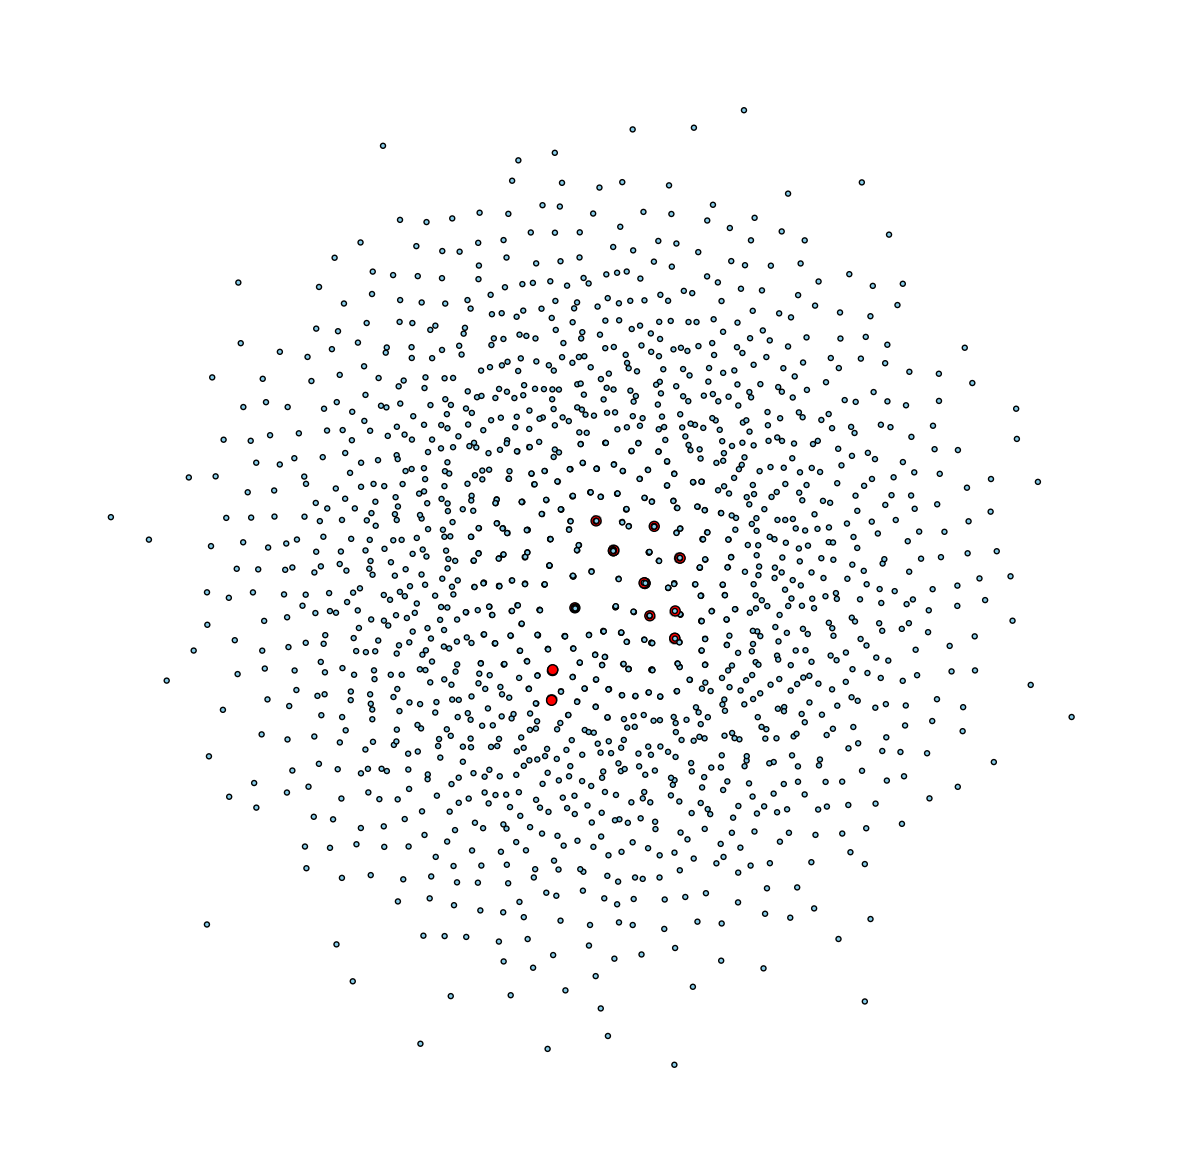

In [355]:
g=snapshots[2004]
g.vs["color"] = "skyblue"
g.es["color"] = "gray"
g.vs["size"] = 5  

degree_threshold = 10
high_degree_nodes = [v.index for v in g.vs if g.degree(v.index) > degree_threshold]
for node in high_degree_nodes:
    g.vs[node]["color"] = "red"
    g.vs[node]["size"] = 10 
    
fig, ax = plt.subplots(figsize=(15,15))
plot(g, target=ax) 
plt.show()

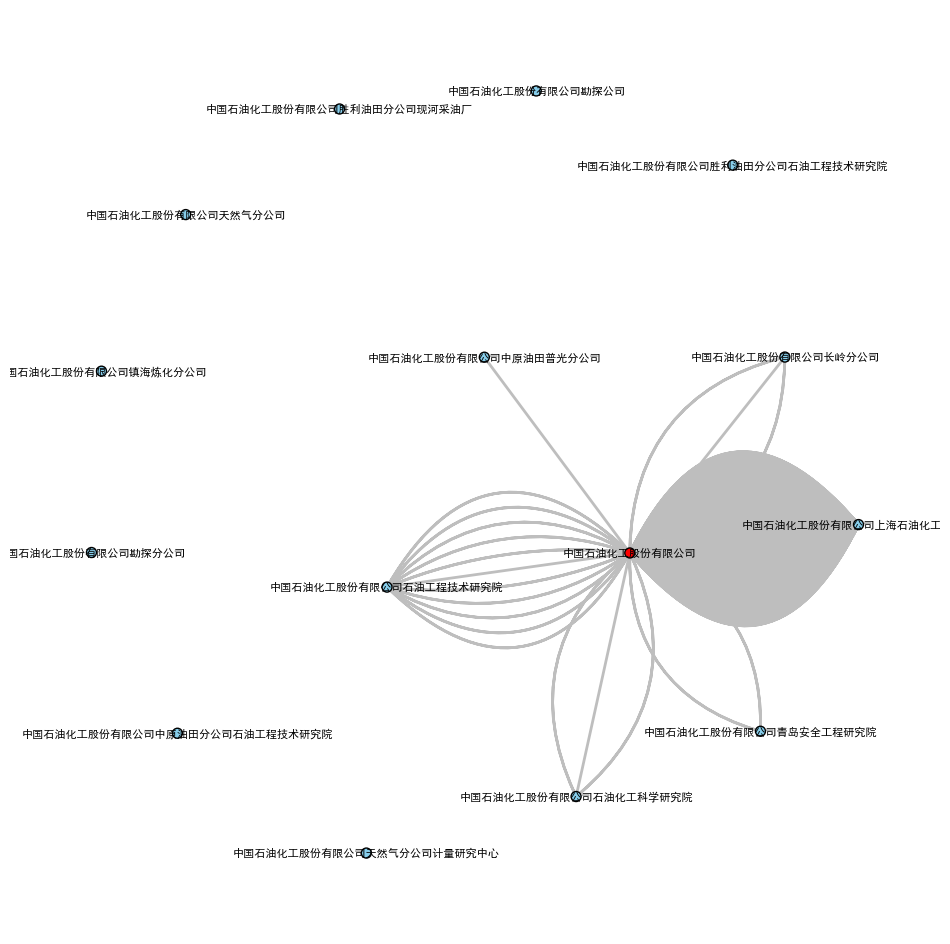

In [354]:
target_company = "中国石油化工股份有限公司"
g=snapshots[2018]
target_nodes = [v.index for v in g.vs if target_company in v['name']] 

subgraph = g.subgraph(target_nodes)

node_colors = ["red" if v['name'] == target_company else "skyblue" for v in subgraph.vs] # 查找目标公司相关节点

# 设置布局
layout = subgraph.layout("kk")  # star,lgl,drl,drl

fig, ax = plt.subplots(figsize=(12, 12))

ig.plot(
    subgraph,
    layout=layout,
    vertex_color=node_colors,
    vertex_size=10,
    edge_color="gray",
    vertex_label=subgraph.vs["name"],  # 设置标签为节点名称
    font_family='SimHei',
    vertex_label_size=8,  # 调整字体大小
    target=ax
)

plt.show()

In [21]:
 # patent_all_tax_gx['cited_applicants'].apply(lambda x: [] if pd.isna(x) else x)

In [25]:
%%time
snapshots = {}
yearly_centrality = []
for year, group in patent_all_tax_gx.groupby('申请年'):
    g = ig.Graph(directed=True) #nx.DiGraph()
    applicants_set =set(group['企业名称'].explode().dropna().unique())|set(group['cited_applicants'].explode().dropna().unique())|set(group['citing_applicants'].explode().dropna().unique())
    g.add_vertices(list(applicants_set))

    added_edges = set() 
    for _, row in group.iterrows():
        application_number = row['申请号']#每个申请号只记录一次引用关系
        edges = set()
        for applicant in row['企业名称']:
            # 申请人 -> 被引证申请人
            if isinstance(row['cited_applicants'], list):
                edges.update((applicant, cited) for cited in row['cited_applicants'])
        
            # 引证申请人 -> 申请人
            if isinstance(row['citing_applicants'], list):
                edges.update((citing, applicant) for citing in row['citing_applicants'])
        
    
        for edge in edges:
            if (application_number,edge) not in added_edges: #如果是不同的申请后的话 添加边 同一个申请号就去重,edge not in added_edges
                g.add_edge(edge[0], edge[1]) 
                added_edges.add((application_number,edge)) # add(edge)


    snapshots[year] = g.copy()

    centralities = {
    'degree_centrality':  g.degree(),#有向无环图（DAG），由于缺乏足够的连接性或循环，导致特征向量中心性（eigenvector centrality）的计算结果为空或为零。
    'betweenness_centrality': g.betweenness(),
    'closeness_centrality': g.closeness(),
    'eigenvector_centrality':  g.eigenvector_centrality()
    }
    
    df = pd.DataFrame(centralities)
    df['year'] = year
    df['company'] = g.vs['name']  
    yearly_centrality.append(df)

    print(year,len(applicants_set),len(added_edges), f'igraph Nodes: {g.vcount()}, Edges: {g.ecount()}')
    
centrality_df = pd.concat(yearly_centrality, ignore_index=True)
centrality_df

#mutual_citations = [(u, v) for u, v in citation_network.edges if citation_network.has_edge(v, u)]

<timed exec>:34: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286
<timed exec>:34: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286
<timed exec>:34: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286
<timed exec>:34: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286
<timed exec>:34: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286


1985 13 igraph Nodes: 13, Edges: 11
1986 25 igraph Nodes: 25, Edges: 22
1987 96 igraph Nodes: 96, Edges: 136
1988 37 igraph Nodes: 37, Edges: 39
1989 24 igraph Nodes: 24, Edges: 21
1990 40 igraph Nodes: 40, Edges: 52
1991 49 igraph Nodes: 49, Edges: 71
1992 135 igraph Nodes: 135, Edges: 123
1993 160 igraph Nodes: 160, Edges: 142
1994 216 igraph Nodes: 216, Edges: 186
1995 316 igraph Nodes: 316, Edges: 296
1996 462 igraph Nodes: 462, Edges: 509
1997 674 igraph Nodes: 674, Edges: 838
1998 895 igraph Nodes: 895, Edges: 967
1999 1612 igraph Nodes: 1612, Edges: 1795
2000 2421 igraph Nodes: 2421, Edges: 2823
2001 5111 igraph Nodes: 5111, Edges: 6607
2002 9207 igraph Nodes: 9207, Edges: 12677
2003 16114 igraph Nodes: 16114, Edges: 25222
2004 22137 igraph Nodes: 22137, Edges: 38188
2005 34728 igraph Nodes: 34728, Edges: 67080
2006 53486 igraph Nodes: 53486, Edges: 108874


KeyboardInterrupt: 

In [34]:
g.is_dag()

False

In [ ]:
if g.is_dag():
    g.to_undirected() 

In [27]:
%%time
snapshots = {}
yearly_centrality = []
for year, group in patent_all_tax_gx.groupby('申请年'):
    g = ig.Graph(directed=True) #nx.DiGraph()
    applicants_set =set(group['企业名称'].explode().dropna().unique())|set(group['cited_applicants'].explode().dropna().unique())|set(group['citing_applicants'].explode().dropna().unique())
    g.add_vertices(list(applicants_set))

    for _, row in group.iterrows():
        edges = set()
        for applicant in row['企业名称']:
            # 申请人 -> 被引证申请人
            if isinstance(row['cited_applicants'], list):
                edges.update((applicant, cited) for cited in row['cited_applicants'])
        
            # 引证申请人 -> 申请人
            if isinstance(row['citing_applicants'], list):
                edges.update((citing, applicant) for citing in row['citing_applicants'])
        
        g.add_edges(list(edges)) 


    snapshots[year] = g.copy()

    centralities = {
    'degree_centrality':  g.degree(),#有向无环图（DAG），由于缺乏足够的连接性或循环，导致特征向量中心性（eigenvector centrality）的计算结果为空或为零。
    'betweenness_centrality': g.betweenness(),
    'closeness_centrality': g.closeness(),
    'eigenvector_centrality':  g.eigenvector_centrality()
    }
    
    df = pd.DataFrame(centralities)
    df['year'] = year
    df['company'] = g.vs['name']  
    yearly_centrality.append(df)

    print(year,len(applicants_set), f'igraph Nodes: {g.vcount()}, Edges: {g.ecount()}')
    
centrality_df = pd.concat(yearly_centrality, ignore_index=True)
centrality_df

<timed exec>:28: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286
<timed exec>:28: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286
<timed exec>:28: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286
<timed exec>:28: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286
<timed exec>:28: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:286


1985 13 igraph Nodes: 13, Edges: 11
1986 25 igraph Nodes: 25, Edges: 22
1987 96 igraph Nodes: 96, Edges: 136
1988 37 igraph Nodes: 37, Edges: 39
1989 24 igraph Nodes: 24, Edges: 21
1990 40 igraph Nodes: 40, Edges: 52
1991 49 igraph Nodes: 49, Edges: 71
1992 135 igraph Nodes: 135, Edges: 123
1993 160 igraph Nodes: 160, Edges: 142
1994 216 igraph Nodes: 216, Edges: 186
1995 316 igraph Nodes: 316, Edges: 296
1996 462 igraph Nodes: 462, Edges: 509
1997 674 igraph Nodes: 674, Edges: 838
1998 895 igraph Nodes: 895, Edges: 967
1999 1612 igraph Nodes: 1612, Edges: 1795
2000 2421 igraph Nodes: 2421, Edges: 2823
2001 5111 igraph Nodes: 5111, Edges: 6607
2002 9207 igraph Nodes: 9207, Edges: 12677
2003 16114 igraph Nodes: 16114, Edges: 25222
2004 22137 igraph Nodes: 22137, Edges: 38188
2005 34728 igraph Nodes: 34728, Edges: 67080
2006 53486 igraph Nodes: 53486, Edges: 108874
2007 74875 igraph Nodes: 74875, Edges: 169285
2008 92651 igraph Nodes: 92651, Edges: 219481
2009 121727 igraph Nodes: 121727

KeyboardInterrupt: 

In [28]:
all_applicants=pd.concat([group['企业名称'].explode().dropna(),group['cited_applicants'].explode().dropna(),group['citing_applicants'].explode().dropna()])
all_applicants.value_counts()

中兴通讯股份有限公司                               7394
珠海格力电器股份有限公司                             5733
京东方科技集团股份有限公司                            4882
海洋王照明科技股份有限公司                            4620
深圳市海洋王照明工程有限公司                           3702
                                         ... 
成都联星技术股份有限公司                                1
Schenck Process Australia Pty Limited       1
李红团                                         1
义马瑞辉新材料有限公司                                 1
Futaba Corporation                          1
Name: count, Length: 251230, dtype: int64

In [32]:
all_applicants.value_counts().loc[g.vs['name']]

佛山市思正能源技术有限公司             2
江苏依斯特电力科技有限公司             2
北京中电网信息技术有限公司             1
Zaitsev Anatoly Petrov    1
国网内蒙古东部电力有限公司电力科学研究院      2
                         ..
天津市进口精密设备新技术发展公司          1
张星                        2
黄信芝                       2
Jolley William A          1
Gen Motors Res Corp       1
Name: count, Length: 251230, dtype: int64

In [64]:
patent_all_tax_gx['cited_applicants'] = patent_all_tax_gx['cited_applicants'].apply(lambda x: x if isinstance(x, list) else [])
patent_all_tax_gx['citing_applicants'] = patent_all_tax_gx['citing_applicants'].apply(lambda x: x if isinstance(x, list) else [])

In [121]:
len(group['cited_applicants'].explode()),len(group['citing_applicants'].explode())

(11628, 5910)

In [83]:
%%time
snapshots = {}
yearly_centrality = []
for year, group in patent_all_tax_gx.groupby('申请年'):
    g = ig.Graph() #nx.DiGraph()directed=True
    all_applicants=pd.concat([group['企业名称'].explode().dropna(),group['cited_applicants'].explode().dropna(),group['citing_applicants'].explode().dropna()]).value_counts()
    g.add_vertices(list(all_applicants.index))
    
    frequency = max(1, len(group) // 100)    
    all_edges = []
    for index, row in group.iterrows():
        edges = set()
        for applicant in row['企业名称']:
            # 申请人 -> 被引证申请人
            edges.update((applicant, cited) for cited in row['cited_applicants']) #frozenset(
        
            # 引证申请人 -> 申请人
            edges.update((citing, applicant) for citing in row['citing_applicants'])
                
        all_edges += list(edges)

        if index % frequency == 0:
            print('.', end='', flush=True)

    edge_weights = defaultdict(int)
    for edge in all_edges:
        edge_weights[tuple(sorted(edge))] += 1 # tuple(frozenset(edge))

    edges, weights = zip(*edge_weights.items())
    g.add_edges(edges) 
    g.es['weight'] = weights

    snapshots[year] = g.copy()

    print('\n',year,len(group),len(all_applicants), len(all_edges),f'igraph Nodes: {g.vcount()}, Edges: {g.ecount()}')

...
 1985 3 13 11 80176 igraph Nodes: 13, Edges: 11
............
 1986 12 25 22 80176 igraph Nodes: 25, Edges: 22
...................
 1987 19 96 136 80176 igraph Nodes: 96, Edges: 117
.............
 1988 13 37 39 80176 igraph Nodes: 37, Edges: 38
......
 1989 6 24 21 80176 igraph Nodes: 24, Edges: 21
..............
 1990 14 40 52 80176 igraph Nodes: 40, Edges: 49
...................
 1991 19 49 71 80176 igraph Nodes: 49, Edges: 70
..............................................
 1992 46 135 123 80176 igraph Nodes: 135, Edges: 117
........................................................................................
 1993 88 160 142 80176 igraph Nodes: 160, Edges: 137
..................................................................................................................................
 1994 130 216 186 80176 igraph Nodes: 216, Edges: 183
.........................................................................................................................................

KeyboardInterrupt: 

In [ ]:
G = ig.Graph() #nx.DiGraph()
yearly_centrality = []
for year,g in snapshots.items():
    new_vertices = set(g.vs['name']) -set(G.vs['name']) if G.vcount() > 0 else set()
    G.add_vertices(list(new_vertices))

    for (src_idx, dst_idx), weight in  zip(iter(g.get_edgelist()), iter(g.es["weight"])):# for edge in g.es:
        src = g.vs[src_idx]["name"] #edge.source
        dst = g.vs[dst_idx]["name"] 

        if G.are_adjacent(src, dst):
            existing_edge = G.es.select(_source=G.vs.find(name=src).index, _target=G.vs.find(name=dst).index)[0]
            existing_edge['weight'] += weight    # g.es['weight'] 如果边已经存在，则仅更新其权重
        else:
            G.add_edge(src, dst, weight=weight)   # 如果边不存在，则添加边并设置权重
    
    centralities = {
    'degree_centrality':  G.degree(),
    'betweenness_centrality': G.betweenness(weights=G.es['weight']),
    'closeness_centrality': G.closeness(weights=G.es['weight']),
    'eigenvector_centrality':  G.eigenvector_centrality(weights=G.es['weight']),
    }
    
    df = pd.DataFrame(centralities)
    df['year'] = year
    df['company'] = G.vs['name']
    # df['count']= all_applicants.loc[g.vs['name']]
    yearly_centrality.append(df)

In [59]:
frozenset([7, 6])

frozenset({6, 7})

In [101]:
from itertools import count
import snap

# 创建一个图
Graph = snap.GenRndGnm(snap.PNGraph, 100, 300)
# 计算节点的介数中心性
Nodes = snap.TIntFltH()
Edges = snap.TIntPrFltH()
snap.GetBetweennessCentr(Graph, Nodes, Edges, 1.0)
# 打印节点的介数中心性
for node in Nodes:
    print(f"Node {node}: {Nodes[node]}")
count()

Node 0: 50.30122638799109
Node 1: 161.16282785841616
Node 2: 34.45645713935188
Node 3: 42.09579391197039
Node 4: 23.501328569091722
Node 5: 39.94491546035663
Node 6: 214.09552566886154
Node 7: 51.52200817758093
Node 8: 168.90403092779252
Node 9: 51.36141399450223
Node 10: 111.78409800553766
Node 11: 0.0
Node 12: 111.17470569935738
Node 13: 97.98091157208802
Node 14: 21.91285452593503
Node 15: 110.03007822500854
Node 16: 39.77825481192354
Node 17: 186.9165627844807
Node 18: 29.495070512562773
Node 19: 115.61900725263729
Node 20: 174.10957999688648
Node 21: 140.26790986790988
Node 22: 112.90187744831705
Node 23: 200.7239272938963
Node 24: 134.69394004258552
Node 25: 115.98191915583556
Node 26: 106.54033794722652
Node 27: 159.87080270091104
Node 28: 0.0
Node 29: 18.531599832915617
Node 30: 124.92251539310362
Node 31: 117.86406240818008
Node 32: 33.77138869902027
Node 33: 68.93895295880587
Node 34: 126.18781002279455
Node 35: 62.36001440939521
Node 36: 55.868230496713466
Node 37: 56.152239

count(0)

In [105]:
del Graph

In [115]:
%%time

snapshots = {}
yearly_centrality = []

for year, group in patent_all_tax_gx.groupby('申请年'):
    # SNAP 无向图
    G = snap.TUNGraph.New()
    all_applicants = pd.concat([group['企业名称'].explode().dropna(), group['cited_applicants'].explode().dropna(), group['citing_applicants'].explode().dropna()]).value_counts()

    node_mapping = {applicant: nid for nid, applicant in enumerate(all_applicants.index)}
    for nid in node_mapping.values():
        G.AddNode(nid)

    # 添加重复边
    frequency = max(1, len(group) // 100)
    for index, row in group.iterrows():
        for applicant in row['企业名称']:
            # 企业 -> 被引证企业
            for cited in row['cited_applicants']:
                G.AddEdge(node_mapping[applicant], node_mapping[cited])

            # 引证企业 -> 申请企业
            for citing in row['citing_applicants']:
                G.AddEdge(node_mapping[citing], node_mapping[applicant])

        if index % frequency == 0:
            print('.', end='', flush=True)


    snapshots[year] = G

    btw_edges = snap.TIntPrFltH()
    btw_centrality = snap.TIntFltH() # 初始化哈希表来存储中间性中心性
    snap.GetBetweennessCentr(G, btw_centrality, btw_edges, 1.0)

    adj_matrix = np.zeros((G.GetNodes(), G.GetNodes()))
    for edge in G.Edges():
        i, j = edge.GetSrcNId(), edge.GetDstNId()
        adj_matrix[i][j] = 1
        adj_matrix[j][i] = 1  # 无向图，邻接矩阵对称
    
    # 计算特征向量中心性
    eigenvalues, eigenvectors = np.linalg.eig(adj_matrix)
    max_eigenvector = np.abs(eigenvectors[:, np.argmax(eigenvalues)])

    centralities = {
        'degree_centrality': {NI.GetId(): NI.GetDeg() for NI in G.Nodes()},
        'betweenness_centrality': dict(btw_centrality),
        'closeness_centrality': {NI.GetId(): snap.GetClosenessCentr(G, NI.GetId()) for NI in G.Nodes()},
        'eigenvector_centrality': {NI.GetId(): centrality for NI, centrality in zip(G.Nodes(), max_eigenvector)},
    }

    # 生成 DataFrame 并存储
    df = pd.DataFrame.from_dict(centralities, orient='index').T
    df['year'] = year
    df['company'] = list(node_mapping.keys())
    df['count'] = all_applicants.loc[list(node_mapping.keys())].values
    yearly_centrality.append(df)

    print(f'\nYear: {year}, Nodes: {G.GetNodes()}, Edges: {G.GetEdges()}')


yearly_centrality_df = pd.concat(yearly_centrality, ignore_index=True)
yearly_centrality_df

...
Year: 1985, Nodes: 13, Edges: 11
............
Year: 1986, Nodes: 25, Edges: 22
...................
Year: 1987, Nodes: 96, Edges: 117
.............
Year: 1988, Nodes: 37, Edges: 38
......
Year: 1989, Nodes: 24, Edges: 21
..............
Year: 1990, Nodes: 40, Edges: 49
...................
Year: 1991, Nodes: 49, Edges: 70
..............................................
Year: 1992, Nodes: 135, Edges: 117
........................................................................................
Year: 1993, Nodes: 160, Edges: 137
..................................................................................................................................
Year: 1994, Nodes: 216, Edges: 183
................................................................................................................................................
Year: 1995, Nodes: 316, Edges: 281
...........................................................................................................................

KeyboardInterrupt: 

In [117]:
df

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,year,company,count
0,283.0,1.317557e+06,0.172236,0.709853,2001,中兴通讯股份有限公司,203
1,265.0,2.456696e+06,0.213253,0.063852,2001,宝山钢铁股份有限公司,144
2,48.0,5.987285e+05,0.187796,0.005745,2001,中国石油化工股份有限公司,102
3,36.0,2.089030e+04,0.158600,0.001603,2001,中国石油化工股份有限公司上海石油化工研究院,90
4,34.0,3.681553e+05,0.182845,0.009797,2001,四川长虹电器股份有限公司,62
...,...,...,...,...,...,...,...
5106,1.0,0.000000e+00,0.114434,0.000600,2001,Hirohisa Sugihara,1
5107,1.0,0.000000e+00,0.114434,0.000600,2001,Takafumi Endo,1
5108,2.0,1.000000e+00,0.000391,0.000000,2001,奎恩科姆有限公司,1
5109,1.0,0.000000e+00,0.119131,0.000016,2001,麦可 罗生布区,1


In [125]:
tax_gx_companies=pd.read_csv('data\\税调与专利.csv', usecols=['企业简称'])
tax_gx_companies

,企业简称
0,ABB新会低压开关
1,ABB新会低压开关
2,ABB新会低压开关
3,ABB新会低压开关
4,ABB新会低压开关
...,...
616045,龙门佳茂聚氨酯橡胶
616046,龙门佳茂聚氨酯橡胶
616047,龙门佳茂聚氨酯橡胶
616048,龙门佳茂聚氨酯橡胶


In [128]:
tax_gx_companies=set(tax_gx_companies.企业简称.unique())
len(tax_gx_companies)

35438

In [130]:
%%time
patent_all_tax_gx['applicants'] = patent_all_tax_gx['企业名称'].apply(lambda x:[i for i in x if clean_short_name(clean_fullname(i)) in tax_gx_companies])
patent_all_tax_gx['cited_applicants'] = patent_all_tax_gx['cited_applicants'].apply(lambda x: [i for i in x if clean_short_name(clean_fullname(i)) in tax_gx_companies] if isinstance(x, list) else [])
patent_all_tax_gx['citing_applicants'] = patent_all_tax_gx['citing_applicants'].apply(lambda x: [i for i in x if clean_short_name(clean_fullname(i)) in tax_gx_companies] if isinstance(x, list) else [])

CPU times: total: 1min 56s
Wall time: 1min 57s


In [131]:
patent_all_tax_gx['applicants'].explode().nunique(),patent_all_tax_gx['cited_applicants'].explode().nunique(),patent_all_tax_gx['citing_applicants'].explode().nunique()

(37376, 25424, 26740)

In [196]:
%%time
snapshots = {}
g = ig.Graph() #nx.DiGraph()
yearly_centrality = []
for year, group in patent_all_tax_gx.groupby('申请年'):
    all_applicants=pd.concat([group['applicants'].explode().dropna(),group['cited_applicants'].explode().dropna(),group['citing_applicants'].explode().dropna()]).value_counts()
    existing_vertices = set(g.vs['name'] if g.vcount() > 0 else [])
    g.add_vertices(list(set(all_applicants.index)- existing_vertices))#g.vs.select(name_eq=applicant)

    edge_weights = defaultdict(int)
    frequency = max(1, len(group) // 100)    
    for index, row in group.iterrows():
        edges = set()
        for applicant in row['applicants']:
            # 申请人 -> 被引证申请人
            edges.update((applicant, cited) for cited in row['cited_applicants']) #frozenset(
            # 引证申请人 -> 申请人
            edges.update((citing, applicant) for citing in row['citing_applicants']) # edge_weights[tuple(sorted((citing, applicant)))] += 1
                
        for edge in edges:
            edge_weights[tuple(sorted(edge))] += 1 # tuple(frozenset(edge))

        if index % frequency == 0:
            print('.', end='', flush=True)

    if not edge_weights:
        continue

    # edges, weights = zip(*edge_weights.items())
    # vertex_index = {v['name']: v.index for v in g.vs}
    for (src, dst), weight in edge_weights.items():
        if g.are_adjacent(src, dst):
            existing_edge = g.es.select(_source=g.vs.find(name=src).index, _target=g.vs.find(name=dst).index)[0]
            existing_edge['weight'] += weight    # g.es['weight'] 如果边已经存在，则仅更新其权重
        else:
            g.add_edge(src, dst, weight=weight)   # 如果边不存在，则添加边并设置权重

    snapshots[year] = g.copy()

    centralities = {
        'degree_centrality':  g.degree(),
        'betweenness_centrality': g.betweenness(weights=g.es['weight']),
        'closeness_centrality': g.closeness(weights=g.es['weight']),
        'eigenvector_centrality':  g.eigenvector_centrality(weights=g.es['weight']),
        }
    
    df = pd.DataFrame(centralities)
    df['year'] = year
    df['company'] = g.vs['name']
    df['count']= all_applicants.reindex(g.vs['name']).values #.fillna(0).astype(int)
    yearly_centrality.append(df)

    print('\n',year,f'unique Edges:{len(edge_weights)}', f'total Edges: {sum(edge_weights.values())}',
          len(group),len(all_applicants), 
          f'igraph Nodes: {g.vcount()}, Edges: {g.ecount()}')

...............
 1986 unique Edges:2 total Edges: 2 12 8 igraph Nodes: 9, Edges: 2
...................
 1987 unique Edges:13 total Edges: 15 19 20 igraph Nodes: 26, Edges: 15
.............
 1988 unique Edges:6 total Edges: 7 13 12 igraph Nodes: 32, Edges: 21
......
 1989 unique Edges:2 total Edges: 2 6 5 igraph Nodes: 34, Edges: 23
..............
 1990 unique Edges:7 total Edges: 10 14 11 igraph Nodes: 42, Edges: 30
...................
 1991 unique Edges:3 total Edges: 3 19 13 igraph Nodes: 52, Edges: 33
..............................................
 1992 unique Edges:17 total Edges: 18 46 35 igraph Nodes: 79, Edges: 49
........................................................................................
 1993 unique Edges:13 total Edges: 13 88 45 igraph Nodes: 111, Edges: 61
..................................................................................................................................
 1994 unique Edges:23 total Edges: 23 130 59 igraph Nodes: 150, Edges: 84
....

In [197]:
yearly_centrality_df = pd.concat(yearly_centrality, ignore_index=True)
yearly_centrality_df

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,year,company,count
0,0,0.000000,NaN,-0.000000e+00,1986,天津市激光技术研究所,NaN
1,0,0.000000,NaN,-0.000000e+00,1986,上海冶金矿山机械厂,NaN
2,0,0.000000,NaN,-0.000000e+00,1986,马鞍山钢铁公司,NaN
3,0,0.000000,NaN,-0.000000e+00,1986,吉林省轻工业设计研究院,NaN
4,0,0.000000,NaN,-0.000000e+00,1986,广东省农业机械研究所,NaN
...,...,...,...,...,...,...,...
410785,1,0.000000,0.192040,4.807970e-13,2019,南京达迈科技实业股份有限公司,NaN
410786,1,0.000000,0.193163,2.675687e-12,2019,北京奥得赛化学股份有限公司,NaN
410787,5,273.917605,0.241576,4.789605e-06,2019,深圳汇茂科技股份有限公司,NaN
410788,1,0.000000,0.204366,3.026595e-12,2019,哈尔滨行健智能机器人有限公司,NaN


In [198]:
yearly_centrality_df['企业简称'] = yearly_centrality_df['company'].apply(clean_fullname).apply(clean_short_name).replace('',pd.NA)
yearly_centrality_df.to_csv('data//tax_gx_centrality_cite_2019.csv',  encoding="utf_8_sig")

In [207]:
all_applicants.reindex(g.vs['name'])

天津市激光技术研究所           1.0
上海冶金矿山机械厂            1.0
马鞍山钢铁公司              1.0
吉林省轻工业设计研究院          NaN
广东省农业机械研究所           NaN
                    ... 
南京达迈科技实业股份有限公司       1.0
北京奥得赛化学股份有限公司        1.0
深圳汇茂科技股份有限公司         3.0
哈尔滨行健智能机器人有限公司       1.0
东莞市劲腾精彩空气处理技术有限公司    2.0
Name: count, Length: 38684, dtype: float64

In [215]:
g.write_pickle("data//tax_gx_centrality_cite_2019_graph.pickle")
g.write_graphml("data//tax_gx_centrality_cite_2019_graph.graphml")

In [211]:
nodes = [{"id": i, "name": v["name"]} for i, v in enumerate(g.vs)]
edges = [{"source": e[0], "target": e[1],"weight":w} for e,w in zip(g.get_edgelist(),g.es["weight"])]

graph_data = {"nodes": nodes, "edges": edges}

In [282]:
def katz_centrality(matrix, alpha=0.1, beta=1.0, max_iter=100, tol=1e-6): #1e-4
    adjacency_matrix = np.array(matrix, dtype=float)
    n = len(adjacency_matrix)
    x = np.ones(n) * beta
    
    # 迭代计算 Katz 中心性
    for _ in range(max_iter):
        x_new = beta + alpha * np.dot(adjacency_matrix, x)
        x_new = np.nan_to_num(x_new)# 处理无效值
        if np.linalg.norm(x_new - x, ord=2) < tol:# 使用 L2 范数,检查收敛性
            break
        x = x_new
        if np.linalg.norm(x, ord=2) != 0:
            x = x / np.linalg.norm(x, ord=2) 
    
    return x

In [283]:
katz_centrality(snapshots[1990].get_adjacency(attribute="weight").data,alpha=0.1, beta=1)

array([0.32047272, 0.32135247, 0.2930963 , 0.30168685, 0.31886794,
       0.2930963 , 0.2930963 , 0.2930963 , 0.2930963 , 0.2930963 ,
       0.2930963 ])

In [285]:
%%time
snapshots = {}
yearly_centrality = []
G = ig.Graph(directed=True)
for year, group in patent_all_tax_gx.groupby('申请年'):
    g = ig.Graph(directed=True) 
    all_applicants=pd.concat([group['applicants'].explode().dropna(),group['cited_applicants'].explode().dropna(),group['citing_applicants'].explode().dropna()]).value_counts()
    g.add_vertices(list(all_applicants.index))
    
    frequency = max(1, len(group) // 100)    
    all_edges = []
    for index, row in group.iterrows():
        edges = set()
        for applicant in row['applicants']:
            # 申请人 -> 被引证申请人
            edges.update((applicant, cited) for cited in row['cited_applicants']) #frozenset(
            # 引证申请人 -> 申请人
            edges.update((citing, applicant) for citing in row['citing_applicants'])
                
        all_edges += list(edges)

        if index % frequency == 0:
            print('.', end='', flush=True)

   
    if not all_edges:
        continue
#-------------------------------------
    edge_weights = Counter(all_edges)
    edges, weights = zip(*edge_weights.items())# for (source, target), weight in edge_weights.items(): #edge, weight 
    g.add_edges(edges) 
    g.es['weight'] = weights

    snapshots[year] = g.copy()
#---------------------------------------
    new_vertices = set(g.vs['name']) - set(G.vs['name'] if G.vcount() > 0 else [])
    G.add_vertices(list(new_vertices))
    # vertex_index = {v['name']: v.index for v in G.vs}
    for (src_idx, dst_idx), weight in zip(iter(g.get_edgelist()), iter(g.es["weight"])):# for edge in g.es:
        src = g.vs[src_idx]["name"] #edge.source
        dst = g.vs[dst_idx]["name"] 

        if G.are_adjacent(src, dst):
            existing_edge = G.es.select(_source=G.vs.find(name=src).index, _target=G.vs.find(name=dst).index)[0] # vertex_index[src], vertex_index[dst]
            existing_edge['weight'] += weight    # g.es['weight'] 如果边已经存在，则仅更新其权重
        else:
            G.add_edge(src, dst, weight=weight)   # 如果边不存在，则添加边并设置权重

    print('\n',year,f'unique Edges: {len(edge_weights)} total Edges: {sum(edge_weights.values())}',
          f'data: {len(group),len(all_applicants),len(all_edges)}', 
          f'igraph Nodes: {g.vcount()}, Edges: {g.ecount()}',f', Graph Nodes: {G.vcount()}, Edges: {G.ecount()}',end=' ')
#---------------------------------------    
    centralities = {
    'degree_centrality': G.degree(mode="all"),
    'log_degree_centrality': [np.log(out_deg + in_deg + 1) for out_deg, in_deg in zip(G.outdegree(), G.indegree())],#lnDC
    'pagerank_scores' : G.pagerank(),
    'betweenness_centrality': G.betweenness(weights=G.es['weight']),
    'closeness_centrality': G.closeness(weights=G.es['weight']),
    'katz_centrality':  katz_centrality(G.get_adjacency(attribute="weight").data,alpha=0.1, beta=1),    # 获取图的邻接矩阵
    }
    if not G.is_dag(): #是否为有向无环图,对于DAG，特征向量中心性通常为零，因为这种类型的图结构没有回路，而特征向量中心性依赖于节点相互影响的循环结构，因此会导致所有的特征值为零。
        centralities['eigenvector_centrality'] = G.eigenvector_centrality(weights=G.es['weight'])
    # else:
    #     g.to_undirected() 
#---------------------------------------    
    df = pd.DataFrame(centralities)
    df['year'] = year
    df['company'] = G.vs['name']
    df['count']= all_applicants.reindex(G.vs['name']).values #.fillna(0).astype(int) all_applicants.loc[g.vs['name']]
    yearly_centrality.append(df)

    print(f'DF: {df.shape}')

...............
 1986 unique Edges: 2 total Edges: 2 data: (12, 8, 2) igraph Nodes: 8, Edges: 2 , Graph Nodes: 8, Edges: 2 DF: (8, 9)
...................
 1987 unique Edges: 13 total Edges: 15 data: (19, 20, 15) igraph Nodes: 20, Edges: 13 , Graph Nodes: 26, Edges: 15 DF: (26, 9)
.............
 1988 unique Edges: 6 total Edges: 7 data: (13, 12, 7) igraph Nodes: 12, Edges: 6 , Graph Nodes: 32, Edges: 21 DF: (32, 10)
......
 1989 unique Edges: 2 total Edges: 2 data: (6, 5, 2) igraph Nodes: 5, Edges: 2 , Graph Nodes: 34, Edges: 23 DF: (34, 10)
..............
 1990 unique Edges: 7 total Edges: 10 data: (14, 11, 10) igraph Nodes: 11, Edges: 7 , Graph Nodes: 42, Edges: 30 DF: (42, 10)
...................
 1991 unique Edges: 3 total Edges: 3 data: (19, 13, 3) igraph Nodes: 13, Edges: 3 , Graph Nodes: 52, Edges: 33 DF: (52, 10)
..............................................
 1992 unique Edges: 17 total Edges: 18 data: (46, 35, 18) igraph Nodes: 35, Edges: 17 , Graph Nodes: 79, Edges: 49 DF: (7

In [287]:
yearly_centrality_df = pd.concat(yearly_centrality, ignore_index=True)
yearly_centrality_df['企业简称'] = yearly_centrality_df['company'].apply(clean_fullname).apply(clean_short_name).replace('',pd.NA)
yearly_centrality_df.to_csv('data//tax_gx_centrality_cite_directed_2019.csv',  encoding="utf_8_sig")

In [350]:
df.columns

Index(['degree_centrality', 'log_degree_centrality', 'pagerank_scores',
       'betweenness_centrality', 'closeness_centrality', 'katz_centrality',
       'eigenvector_centrality', 'year', 'company', 'count'],
      dtype='object')

In [347]:
df.sort_values(by='log_degree_centrality').tail()

,degree_centrality,log_degree_centrality,pagerank_scores,betweenness_centrality,closeness_centrality,katz_centrality,eigenvector_centrality,year,company,count
61,2362,7.767687,0.003126,2.097432e+07,0.350248,0.009116,0.022298,2019,京东方科技集团股份有限公司,9824.0
340,3416,8.136518,0.002799,3.226701e+07,0.347593,0.479279,0.265245,2019,华为技术有限公司,2975.0
302,3887,8.265650,0.002475,1.454798e+07,0.330741,0.869209,1.000000,2019,中兴通讯股份有限公司,4261.0
191,4025,8.300529,0.003290,4.319884e+07,0.356868,0.006336,0.010261,2019,比亚迪股份有限公司,3396.0
134,5194,8.555452,0.009438,6.028251e+07,0.369513,0.008972,0.066790,2019,珠海格力电器股份有限公司,21157.0


In [351]:
df.sort_values(by='betweenness_centrality').tail()

,degree_centrality,log_degree_centrality,pagerank_scores,betweenness_centrality,closeness_centrality,katz_centrality,eigenvector_centrality,year,company,count
61,2362,7.767687,0.003126,2.097432e+07,0.350248,0.009116,0.022298,2019,京东方科技集团股份有限公司,9824.0
340,3416,8.136518,0.002799,3.226701e+07,0.347593,0.479279,0.265245,2019,华为技术有限公司,2975.0
28,2310,7.745436,0.001921,3.329321e+07,0.357542,0.000441,0.000138,2019,宝山钢铁股份有限公司,901.0
191,4025,8.300529,0.003290,4.319884e+07,0.356868,0.006336,0.010261,2019,比亚迪股份有限公司,3396.0
134,5194,8.555452,0.009438,6.028251e+07,0.369513,0.008972,0.066790,2019,珠海格力电器股份有限公司,21157.0


In [348]:
df.sort_values(by='pagerank_scores').tail()

,degree_centrality,log_degree_centrality,pagerank_scores,betweenness_centrality,closeness_centrality,katz_centrality,eigenvector_centrality,year,company,count
302,3887,8.265650,0.002475,1.454798e+07,0.330741,0.869209,1.000000,2019,中兴通讯股份有限公司,4261.0
340,3416,8.136518,0.002799,3.226701e+07,0.347593,0.479279,0.265245,2019,华为技术有限公司,2975.0
61,2362,7.767687,0.003126,2.097432e+07,0.350248,0.009116,0.022298,2019,京东方科技集团股份有限公司,9824.0
191,4025,8.300529,0.003290,4.319884e+07,0.356868,0.006336,0.010261,2019,比亚迪股份有限公司,3396.0
134,5194,8.555452,0.009438,6.028251e+07,0.369513,0.008972,0.066790,2019,珠海格力电器股份有限公司,21157.0


In [349]:
df.sort_values(by='katz_centrality').tail()

,degree_centrality,log_degree_centrality,pagerank_scores,betweenness_centrality,closeness_centrality,katz_centrality,eigenvector_centrality,year,company,count
359,167,5.123964,0.000076,3.510655e+05,0.306488,0.030292,0.035930,2019,电信科学技术研究院,113.0
1641,953,6.860664,0.000646,4.290331e+06,0.318383,0.030742,0.030871,2019,宇龙计算机通信科技(深圳)有限公司,322.0
348,517,6.249975,0.000267,1.872397e+06,0.315181,0.072961,0.052733,2019,大唐移动通信设备有限公司,171.0
340,3416,8.136518,0.002799,3.226701e+07,0.347593,0.479279,0.265245,2019,华为技术有限公司,2975.0
302,3887,8.265650,0.002475,1.454798e+07,0.330741,0.869209,1.000000,2019,中兴通讯股份有限公司,4261.0


In [355]:
df.sort_values(by='count',ascending=False).head()

,degree_centrality,log_degree_centrality,pagerank_scores,betweenness_centrality,closeness_centrality,katz_centrality,eigenvector_centrality,year,company,count
134,5194,8.555452,0.009438,6.028251e+07,0.369513,0.008972,0.066790,2019,珠海格力电器股份有限公司,21157.0
61,2362,7.767687,0.003126,2.097432e+07,0.350248,0.009116,0.022298,2019,京东方科技集团股份有限公司,9824.0
176,1179,7.073270,0.001482,6.481346e+06,0.335274,0.002517,0.012652,2019,广东美的制冷设备有限公司,5780.0
302,3887,8.265650,0.002475,1.454798e+07,0.330741,0.869209,1.000000,2019,中兴通讯股份有限公司,4261.0
850,1824,7.509335,0.001773,4.341230e+06,0.323148,0.022720,0.057911,2019,百度在线网络技术(北京)有限公司,4228.0


In [290]:
len(snapshots)

34

In [324]:
import json
import pickle
import h5py
import numpy as np

# if "name" in g.vs.attributes()
node_data = np.array([name.encode('utf-8') for name in G.vs["name"]])#dtype='S'.astype(np.string_)
edge_data = np.array(G.get_edgelist(), dtype=int) 
# if "weight" in g.es.attributes():
weights = np.array(G.es["weight"], dtype=float)

with h5py.File("data//tax_gx_cite_directed_graph_2019.h5", "w") as f:
    f.create_dataset("nodes", data=node_data)
    f.create_dataset("edges", data=edge_data)
    f.create_dataset("weights", data=weights)

# snapshots_json = {year: g.to_dictionary() for year, g in snapshots.items()}
# with open("data//tax_gx_cite_directed_graph_snapshots.json", "w") as f:
#     json.dump(snapshots_json, f)
    
with open("data//tax_gx_cite_directed_graph_snapshots.pkl", "wb") as f:
    pickle.dump(snapshots, f)

# with open("data//tax_gx_cite_directed_graph_snapshots.pkl", "rb") as f:
#     snapshots_1 = pickle.load(f)

In [325]:
# vertex_names = group["nodes"][:].astype(str)
# g.add_vertices(len(vertex_names))
# g.vs["name"] = vertex_names

# edges = group["edges"][:]
# g.add_edges(edges)

# weights = group["weights"][:]
# g.es["weight"] = weights

In [335]:
vertex_index = {v['name']: v.index for v in G.vs}

In [334]:
G.vs.find(name='中国科学院力学研究所').index,G.vs.find(name='上海印钞厂').index,G.vs.find(name='北京光电技术研究所').index,G.vs.find(name='中国科学院山西煤炭化学研究所').index,G.vs.find(name='浙江吉利汽车有限公司').index

(3, 24, 7, 118, 143)

In [344]:
vertex_index['上海印钞厂'],G.vs.find(name='上海印钞厂')

(24,
 igraph.Vertex(<igraph.Graph object at 0x000001AE4ED4FD40>, 24, {'name': '上海印钞厂'}))

In [339]:
G.are_adjacent('中国科学院力学研究所','北京光电技术研究所')

False

In [342]:
G.are_adjacent('上海印钞厂','北京光电技术研究所')

False

In [338]:
G.es.select(_source=3, _target=7)

In [288]:
g.vertex_attributes(),G.vertex_attributes()

(['name'], ['name'])

In [345]:
id(g),id(G)

(1849902163776, 1848158518592)

In [299]:
G.is_dag()

False

In [318]:
np.array(g.get_edgelist())

array([[ 1717,  6031],
       [    1,  3007],
       [    1,     1],
       ...,
       [ 1331,    44],
       [ 1184,   161],
       [10825,  1382]])

In [316]:
%%time
np.unique(all_applicants.values, return_counts=True)

CPU times: total: 0 ns
Wall time: 1 ms


(array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
           10,    11,    12,    13,    14,    15,    16,    17,    18,
           19,    20,    21,    22,    23,    24,    25,    26,    27,
           28,    29,    30,    31,    32,    33,    34,    35,    36,
           37,    38,    39,    40,    41,    42,    43,    44,    45,
           46,    47,    48,    49,    50,    51,    52,    53,    54,
           55,    56,    57,    58,    59,    60,    61,    62,    63,
           64,    65,    66,    67,    68,    69,    70,    71,    72,
           73,    74,    75,    76,    77,    78,    79,    80,    81,
           82,    83,    84,    85,    86,    87,    88,    89,    90,
           91,    92,    93,    94,    95,    96,    97,    98,    99,
          100,   101,   102,   103,   104,   105,   106,   107,   108,
          109,   110,   111,   112,   113,   114,   115,   116,   117,
          118,   119,   120,   121,   123,   124,   125,   126,   127,
      